In [1]:
# Standard library
%pip install numpy pandas torch seaborn matplotlib datasets transformers
%pip install "accelerate>=0.26.0"

import os
import csv
import json
import re
from collections import defaultdict

# Third-party
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForTokenClassification,
    Trainer,
    TrainingArguments,
    DataCollatorForTokenClassification,
)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/Users/Nirsho/CS/NLP/NLP_final/NLP_final_project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialize Hugging Face Transformers—pipeline, tokenizer, and the CAMeL-Lab CAMeLBERT MSA POS model—as the baseline Arabic POS tagging setup for this experiment.

In [2]:

pipe = pipeline("token-classification", model="CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa")

# Load model directly

tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa")
model = AutoModelForTokenClassification.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa")



Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the chec

Load the manually annotated Arabic POS CSV and build dialect_dict (dialect → tokenized, tagged sentences) to prepare for cross-dialect evaluation.

In [3]:
# A dictionary that groups examples by dialect, each value is a list of entries.
dialect_dict = defaultdict(list)

# Read the cleaned manual annotations CSV (UTF-8), one dict per row.
with open("manual_annotations_cleaned.csv", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Tokenize: capture either word chunks (\w+) or single non-space punctuation ([^\w\s])
        tokens = re.findall(r'\w+|[^\w\s]', row['sentence'], re.UNICODE)

        # Gold POS tags are stored space-separated in the CSV
        pos_tags = row['pos_tags'].split()

        # Dialect label for this sentence (e.g., MSA/Egyptian/Levant/etc.)
        dialect = row['dialect']

        # Pack the example with both raw and tokenized views plus metadata
        entry = {
            'sentence': row['sentence'],
            'tokens': tokens,
            'pos_tags': pos_tags,
            'token_count': int(row['token_count']),
            'sentence_id': int(row['sentence_id']),
        }

        # Append the example under its dialect bucket
        dialect_dict[dialect].append(entry)


Generate baseline POS predictions per sentence and merge subword pieces into whole tokens, saving model_tokens/model_pos_tags in each dialect entry for evaluation. For further information refer to Methodology/Unknown tokens in the report

In [4]:
for dialect in dialect_dict.keys():
    for entry in dialect_dict[dialect]:
        text = entry['sentence']
        raw_model_output = pipe(text)  # run zero-shot POS tagging on the raw sentence

        merged_tokens = []  # final word-level tokens after merging subwords
        merged_tags = []    # corresponding POS tags (taken from the first subword)

        buffer = ""         # accumulates WordPiece continuations (tokens starting with "##")
        current_tag = None  # tag associated with the current (to-be-merged) word

        for token in raw_model_output:
            word = token['word']
            tag = token['entity']

            if word.startswith("##"):
                buffer += word[2:]  # append continuation subword (drop the "##" prefix)
            else:
                # starting a new word boundary: flush previous buffered word (if any)
                if buffer:
                    merged_tokens.append(buffer)
                    merged_tags.append(current_tag)
                buffer = word        # start buffering the new base subword
                current_tag = tag    # remember its tag (used for the whole merged word)

        # flush the final buffered word (if any) after the loop ends
        if buffer:
            merged_tokens.append(buffer)
            merged_tags.append(current_tag)

        # attach model predictions (word-level) back to the entry for later evaluation
        entry["model_tokens"] = merged_tokens
        entry["model_pos_tags"] = merged_tags


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Score the model zero-shot on each dialect, tally TP/FP/FN per POS tag, collect (gold,pred) mismatch pairs for error analysis, and display per-dialect F1 tables.

In [5]:
dialect_res = {}
overall_counts = defaultdict(lambda: {"TP":0,"FP":0,"FN":0})  # aggregated across dialects
mismatch_pairs = defaultdict(int)
our_tags, model_tags = set(), set()

for dialect in sorted(dialect_dict.keys()):
    tag_counts = defaultdict(lambda: {"TP":0,"FP":0,"FN":0})
    print(dialect)

    for entry in dialect_dict[dialect]:
        # Pair gold vs predicted tags positionally
        for gold_tag, pred_tag in zip(entry["pos_tags"], entry["model_pos_tags"]):
            our_tags.add(gold_tag)
            model_tags.add(pred_tag)

            if gold_tag == pred_tag:
                tag_counts[gold_tag]["TP"] += 1
                overall_counts[gold_tag]["TP"] += 1
            else:
                tag_counts[gold_tag]["FN"] += 1
                tag_counts[pred_tag]["FP"] += 1
                overall_counts[gold_tag]["FN"] += 1
                overall_counts[pred_tag]["FP"] += 1
                mismatch_pairs[(gold_tag, pred_tag)] += 1

    dialect_res[dialect] = tag_counts

zero_shot_tables = {}
for dialect, tag_counts in dialect_res.items():
    rows = []
    for tag, c in tag_counts.items():
        tp, fp, fn = c["TP"], c["FP"], c["FN"]
        support_recall   = tp + fn
        support_precision = tp + fp
        precision = tp / support_precision if support_precision else 0.0
        recall    = tp / support_recall    if support_recall    else 0.0   # normalized by gold share
        f1        = (2*precision*recall)/(precision+recall) if (precision+recall) else 0.0

        rows.append({
            "POS Tag": tag,
            "TP": tp, "FP": fp, "FN": fn,
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1": round(f1, 3)
        })

    df = pd.DataFrame(rows).set_index("POS Tag").sort_values(by="F1", ascending=False)
    zero_shot_tables[dialect] = df
    print(f"\n==== Tag Metrics for {dialect} ====\n")
    try:
        display(df)
    except Exception:
        print(df.to_string())


Beirut
Cairo
Doha
Jerusalem
MSA
Rabat
Tunis

==== Tag Metrics for Beirut ====



,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
noun_quant,4,0,0,1.000,1.000,1.000
punc,111,2,24,0.982,0.822,0.895
conj,11,2,1,0.846,0.917,0.880
conj_sub,8,1,4,0.889,0.667,0.762
adj_comp,1,1,0,0.500,1.000,0.667
prep,19,2,19,0.905,0.500,0.644
noun,121,75,60,0.617,0.669,0.642
adj,20,12,18,0.625,0.526,0.571
pron,4,0,7,1.000,0.364,0.533



==== Tag Metrics for Cairo ====



,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
part_voc,2,0,0,1.000,1.000,1.000
punc,112,0,18,1.000,0.862,0.926
conj,11,0,3,1.000,0.786,0.880
pron,13,0,4,1.000,0.765,0.867
prep,26,2,15,0.929,0.634,0.754
verb,71,18,31,0.798,0.696,0.743
noun,135,60,38,0.692,0.780,0.734
conj_sub,10,1,7,0.909,0.588,0.714
adj,33,8,31,0.805,0.516,0.629



==== Tag Metrics for Doha ====



,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
pron,5,0,1,1.000,0.833,0.909
punc,99,1,28,0.990,0.780,0.872
adj_num,3,1,0,0.750,1.000,0.857
noun_quant,2,1,0,0.667,1.000,0.800
conj_sub,9,0,6,1.000,0.600,0.750
verb,68,5,41,0.932,0.624,0.747
prep,30,2,21,0.938,0.588,0.723
adj,27,5,18,0.844,0.600,0.701
noun_num,10,4,5,0.714,0.667,0.690



==== Tag Metrics for Jerusalem ====



,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
conj,10,0,1,1.000,0.909,0.952
punc,131,0,18,1.000,0.879,0.936
conj_sub,15,2,4,0.882,0.789,0.833
prep,35,3,17,0.921,0.673,0.778
pron,6,0,4,1.000,0.600,0.750
noun,152,96,38,0.613,0.800,0.694
noun_num,13,2,10,0.867,0.565,0.684
adj,30,11,18,0.732,0.625,0.674
verb,57,21,59,0.731,0.491,0.588



==== Tag Metrics for MSA ====



,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
part_voc,2,0,0,1.000,1.000,1.000
part_fut,2,0,0,1.000,1.000,1.000
pron_dem,21,0,1,1.000,0.955,0.977
pron,12,0,1,1.000,0.923,0.960
part_interrog,21,0,3,1.000,0.875,0.933
conj_sub,20,1,2,0.952,0.909,0.930
punc,107,1,17,0.991,0.863,0.922
verb,89,5,12,0.947,0.881,0.913
prep,65,1,17,0.985,0.793,0.878



==== Tag Metrics for Rabat ====



,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
adj_comp,2,0,0,1.000,1.000,1.000
punc,129,0,8,1.000,0.942,0.970
conj,11,0,2,1.000,0.846,0.917
verb,70,10,46,0.875,0.603,0.714
noun,126,93,53,0.575,0.704,0.633
pron,4,0,6,1.000,0.400,0.571
adj,20,16,15,0.556,0.571,0.563
prep,21,2,39,0.913,0.350,0.506
part_restrict,1,1,1,0.500,0.500,0.500



==== Tag Metrics for Tunis ====



,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
adj_comp,1,0,0,1.000,1.000,1.000
part_voc,2,0,0,1.000,1.000,1.000
pron,6,0,0,1.000,1.000,1.000
punc,107,0,25,1.000,0.811,0.895
conj,11,0,4,1.000,0.733,0.846
verb,79,14,31,0.849,0.718,0.778
noun,134,62,37,0.684,0.784,0.730
prep,20,4,11,0.833,0.645,0.727
adj,20,6,16,0.769,0.556,0.645


In [6]:
def _exclude_punc(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return df
    return df[df.index.str.lower() != "punc"]

best_tags_by_dialect = {}
for dialect, df in zero_shot_tables.items():
    tmp = _exclude_punc(df)
    if tmp is None or tmp.empty:
        continue
    best_tag = tmp["Recall"].idxmax()
    row = tmp.loc[best_tag]

    best_tags_by_dialect[dialect] = {
        "POS Tag": best_tag,
        "Recall": float(row["Recall"]),

    }

In [7]:
Z = 1.96            # 95% confidence
MIN_SUPPORT = 0

def add_conservative_metrics(df_counts: pd.DataFrame) -> pd.DataFrame:
    """
    df_counts: index=tag, columns must include TP, FP, FN.
    Returns a copy with Prec, Rec, Prec_LB, Rec_LB, and F1_LB (conservative).
    """
    if df_counts is None or df_counts.empty:
        return df_counts

    out = df_counts.copy()
    out = out[out.index.str.lower() != "punc"]

    tp = out["TP"].astype(float)
    fp = out["FP"].astype(float)
    fn = out["FN"].astype(float)

    # Supports
    n_rec  = tp + fn   # denominator for recall
    n_prec = tp + fp   # denominator for precision

    # Point estimates (reference only)
    out["Precision"] = np.divide(tp, n_prec, out=np.zeros_like(tp), where=n_prec>0)
    out["Recall"]    = np.divide(tp, n_rec,  out=np.zeros_like(tp), where=n_rec>0)

    # Wilson lower bounds
    out["Precision_LB"] = wilson_lb(tp, n_prec, z=Z)
    out["Recall_LB"]    = wilson_lb(tp, n_rec,  z=Z)

    # Conservative F1 using the LBs
    num = 2 * (out["Precision_LB"] * out["Recall_LB"])
    den = out["Precision_LB"] + out["Recall_LB"]
    f_lb = np.divide(num, den, out=np.zeros_like(num), where=den > 0)

    out["F1_LB"] = f_lb

    # Keep supports for context
    out["Support_recall"]    = n_rec.astype(int)
    out["Support_precision"] = n_prec.astype(int)
    return out

def wilson_lb(successes, n, z=Z):
    successes = successes.astype(float)
    n = n.astype(float)
    # proportion
    p = np.divide(successes, n, out=np.zeros_like(successes, dtype=float), where=n>0)
    den    = 1.0 + (z**2)/n
    center = p + (z**2)/(2*n)
    adj    = z * np.sqrt(np.divide(p*(1-p), n, out=np.zeros_like(n, dtype=float), where=n>0) + (z**2)/(4*(n**2)))
    lb = (center - adj) / den
    lb = np.where(n>0, lb, 0.0)
    return lb

if 'overall_df' in locals() and not overall_df.empty:
    overall_cons = add_conservative_metrics(overall_df[["TP","FP","FN"]])
    if overall_cons is not None and not overall_cons.empty:
        overall_ranked = overall_cons.sort_values("Recall_LB", ascending=False)
        top = overall_ranked.iloc[0]



# Per-dialect Wilson ranking (Recall-only LB)
best_by_dialect_wilson = {}
for d, df in zero_shot_tables.items():  # or zero_shot_tabels
    per_counts = df[["TP","FP","FN"]].copy()
    cons = add_conservative_metrics(per_counts)
    if cons is None or cons.empty:
        continue
    ranked = cons.sort_values("Recall_LB", ascending=False)
    top = ranked.iloc[0]
    best_by_dialect_wilson[d] = {
        "POS Tag": ranked.index[0],
        "Recall": float(top["Recall"]),
        "LB": float(top["Recall_LB"]),
        "Support_recall": int(top["Support_recall"]),
        "Support_precision": int(top["Support_precision"]),
    }


In [8]:
# Overall: conservative F1 (LB)
overall_counts_df = pd.DataFrame(overall_counts).T if 'overall_counts' in locals() else pd.DataFrame()
if not overall_counts_df.empty:
    overall_cons = add_conservative_metrics(overall_counts_df)
    if overall_cons is not None and not overall_cons.empty:
        ranked_cons = overall_cons.sort_values("F1_LB", ascending=False)
        best = ranked_cons.index[0]
        print(f"\nBest tag OVERALL by conservative F1 (LB, excl. 'punc'): {best} | "
              f"F1_LB={ranked_cons.iloc[0]['F1_LB']:.3f} | "
              f"Prec_LB={ranked_cons.iloc[0]['Precision_LB']:.3f} | Rec_LB={ranked_cons.iloc[0]['Recall_LB']:.3f} | "
              f"Support(rec)={ranked_cons.iloc[0]['Support_recall']} | Support(prec)={ranked_cons.iloc[0]['Support_precision']}")
        try:
            display(
                ranked_cons.loc[:, ["TP","FP","FN","Support_recall","Support_precision",
                                    "Precision","Recall","Precision_LB","Recall_LB","F1_LB"]]
                  .head(10)
                  .style.format({"Precision":"{:.3f}","Recall":"{:.3f}",
                                 "Precision_LB":"{:.3f}","Recall_LB":"{:.3f}","F1_LB":"{:.3f}"})
                  .set_caption("Top tags overall by conservative F1 (Wilson LBs, excl. 'punc')")
            )
        except Exception:
            print(
                ranked_cons[["TP","FP","FN","Support_recall","Support_precision",
                             "Precision","Recall","Precision_LB","Recall_LB","F1_LB"]]
                .head(10)
                .to_string(float_format=lambda x: f"{x:.3f}")
            )

# Per-dialect: conservative F1 (LB)
best_by_dialect_cons = {}
for d, df in zero_shot_tables.items():
    per_counts = df[["TP","FP","FN"]].copy()
    cons = add_conservative_metrics(per_counts)
    if cons is None or cons.empty:
        continue
    r = cons.sort_values("F1_LB", ascending=False)
    best_by_dialect_cons[d] = {
        "POS Tag": r.index[0],
        "F1_LB": float(r.iloc[0]["F1_LB"]),
        "Precision_LB": float(r.iloc[0]["Precision_LB"]),
        "Recall_LB": float(r.iloc[0]["Recall_LB"]),
        "Support_recall": int(r.iloc[0]["Support_recall"]),
        "Support_precision": int(r.iloc[0]["Support_precision"]),
    }
    print(f"[{d}] best tag by conservative F1 (LB, excl. 'punc'): {r.index[0]} | "
          f"F1_LB={r.iloc[0]['F1_LB']:.3f} | Prec_LB={r.iloc[0]['Precision_LB']:.3f} | Rec_LB={r.iloc[0]['Recall_LB']:.3f} | "
          f"Support(rec)={int(r.iloc[0]['Support_recall'])} | Support(prec)={int(r.iloc[0]['Support_precision'])}")
    try:
        display(
            r.loc[:, ["TP","FP","FN","Support_recall","Support_precision",
                      "Precision","Recall","Precision_LB","Recall_LB","F1_LB"]]
             .head(15)
             .style.format({"Precision":"{:.3f}","Recall":"{:.3f}",
                            "Precision_LB":"{:.3f}","Recall_LB":"{:.3f}","F1_LB":"{:.3f}"})
             .set_caption(f"Top tags by conservative F1 (LB) for {d} (excl. 'punc')")
        )
    except Exception:
        print(
            r[["TP","FP","FN","Support_recall","Support_precision",
               "Precision","Recall","Precision_LB","Recall_LB","F1_LB"]]
            .head(15)
            .to_string(float_format=lambda x: f"{x:.3f}")
        )


Best tag OVERALL by conservative F1 (LB, excl. 'punc'): conj | F1_LB=0.767 | Prec_LB=0.890 | Rec_LB=0.675 | Support(rec)=77.0 | Support(prec)=62.0


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
conj,60,2,17,77,62,0.968,0.779,0.890,0.675,0.767
pron,50,0,23,73,50,1.000,0.685,0.929,0.571,0.707
noun,998,523,287,1285,1521,0.656,0.777,0.632,0.753,0.687
prep,216,16,139,355,232,0.931,0.608,0.891,0.557,0.685
verb,468,91,295,763,559,0.837,0.613,0.804,0.578,0.673
conj_sub,65,5,36,101,70,0.929,0.644,0.843,0.546,0.663
part_voc,6,0,0,6,6,1.000,1.000,0.610,0.610,0.610
adj,186,62,133,319,248,0.750,0.583,0.693,0.528,0.599
noun_num,52,23,52,104,75,0.693,0.500,0.582,0.406,0.478
pron_dem,36,0,63,99,36,1.000,0.364,0.904,0.276,0.422


[Beirut] best tag by conservative F1 (LB, excl. 'punc'): conj | F1_LB=0.610 | Prec_LB=0.578 | Rec_LB=0.646 | Support(rec)=12 | Support(prec)=13


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
conj,11,2,1,12,13,0.846,0.917,0.578,0.646,0.610
noun,121,75,60,181,196,0.617,0.669,0.548,0.597,0.571
noun_quant,4,0,0,4,4,1.000,1.000,0.510,0.510,0.510
prep,19,2,19,38,21,0.905,0.500,0.711,0.348,0.468
conj_sub,8,1,4,12,9,0.889,0.667,0.565,0.391,0.462
adj,20,12,18,38,32,0.625,0.526,0.453,0.373,0.409
verb,34,18,75,109,52,0.654,0.312,0.518,0.233,0.321
noun_num,5,2,7,12,7,0.714,0.417,0.359,0.193,0.251
pron,4,0,7,11,4,1.000,0.364,0.510,0.152,0.234


[Cairo] best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.666 | Prec_LB=0.624 | Rec_LB=0.713 | Support(rec)=173 | Support(prec)=195


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,135,60,38,173,195,0.692,0.780,0.624,0.713,0.666
verb,71,18,31,102,89,0.798,0.696,0.703,0.601,0.648
pron,13,0,4,17,13,1.000,0.765,0.772,0.527,0.627
conj,11,0,3,14,11,1.000,0.786,0.741,0.524,0.614
prep,26,2,15,41,28,0.929,0.634,0.774,0.481,0.593
adj,33,8,31,64,41,0.805,0.516,0.660,0.396,0.495
conj_sub,10,1,7,17,11,0.909,0.588,0.623,0.360,0.456
part_voc,2,0,0,2,2,1.000,1.000,0.342,0.342,0.342
pron_interrog,3,2,3,6,5,0.600,0.500,0.231,0.188,0.207


[Doha] best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.653 | Prec_LB=0.849 | Rec_LB=0.530 | Support(rec)=109 | Support(prec)=73


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,68,5,41,109,73,0.932,0.624,0.849,0.530,0.653
noun,124,78,41,165,202,0.614,0.752,0.545,0.680,0.605
prep,30,2,21,51,32,0.938,0.588,0.799,0.452,0.577
adj,27,5,18,45,32,0.844,0.600,0.682,0.455,0.546
pron,5,0,1,6,5,1.000,0.833,0.566,0.436,0.493
conj_sub,9,0,6,15,9,1.000,0.600,0.701,0.357,0.473
noun_num,10,4,5,15,14,0.714,0.667,0.454,0.417,0.435
adj_num,3,1,0,3,4,0.750,1.000,0.301,0.438,0.357
conj,3,0,3,6,3,1.000,0.500,0.438,0.188,0.263


[Jerusalem] best tag by conservative F1 (LB, excl. 'punc'): conj | F1_LB=0.669 | Prec_LB=0.722 | Rec_LB=0.623 | Support(rec)=11 | Support(prec)=10


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
conj,10,0,1,11,10,1.000,0.909,0.722,0.623,0.669
prep,35,3,17,52,38,0.921,0.673,0.792,0.538,0.640
noun,152,96,38,190,248,0.613,0.800,0.551,0.737,0.631
conj_sub,15,2,4,19,17,0.882,0.789,0.657,0.567,0.608
adj,30,11,18,48,41,0.732,0.625,0.581,0.484,0.528
verb,57,21,59,116,78,0.731,0.491,0.623,0.402,0.489
noun_num,13,2,10,23,15,0.867,0.565,0.621,0.368,0.462
pron,6,0,4,10,6,1.000,0.600,0.610,0.313,0.413
noun_prop,14,94,2,16,108,0.130,0.875,0.079,0.640,0.140


[MSA] best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.841 | Prec_LB=0.881 | Rec_LB=0.804 | Support(rec)=101 | Support(prec)=94


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,89,5,12,101,94,0.947,0.881,0.881,0.804,0.841
pron_dem,21,0,1,22,21,1.000,0.955,0.845,0.782,0.812
prep,65,1,17,82,66,0.985,0.793,0.919,0.693,0.790
noun,206,59,20,226,265,0.777,0.912,0.724,0.867,0.789
part_interrog,21,0,3,24,21,1.000,0.875,0.845,0.690,0.760
conj_sub,20,1,2,22,21,0.952,0.909,0.773,0.722,0.747
pron,12,0,1,13,12,1.000,0.923,0.757,0.667,0.709
adj,36,4,17,53,40,0.900,0.679,0.769,0.545,0.638
noun_num,11,8,0,11,19,0.579,1.000,0.363,0.741,0.487


[Rabat] best tag by conservative F1 (LB, excl. 'punc'): conj | F1_LB=0.649 | Prec_LB=0.741 | Rec_LB=0.578 | Support(rec)=13 | Support(prec)=11


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
conj,11,0,2,13,11,1.000,0.846,0.741,0.578,0.649
verb,70,10,46,116,80,0.875,0.603,0.785,0.512,0.620
noun,126,93,53,179,219,0.575,0.704,0.509,0.633,0.564
adj,20,16,15,35,36,0.556,0.571,0.396,0.409,0.402
prep,21,2,39,60,23,0.913,0.350,0.732,0.242,0.363
adj_comp,2,0,0,2,2,1.000,1.000,0.342,0.342,0.342
pron,4,0,6,10,4,1.000,0.400,0.510,0.168,0.253
pron_dem,4,0,12,16,4,1.000,0.250,0.510,0.102,0.170
part_restrict,1,1,1,2,2,0.500,0.500,0.095,0.095,0.095


[Tunis] best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.689 | Prec_LB=0.763 | Rec_LB=0.628 | Support(rec)=110 | Support(prec)=93


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,79,14,31,110,93,0.849,0.718,0.763,0.628,0.689
noun,134,62,37,171,196,0.684,0.784,0.616,0.716,0.662
pron,6,0,0,6,6,1.000,1.000,0.610,0.610,0.610
conj,11,0,4,15,11,1.000,0.733,0.741,0.480,0.583
prep,20,4,11,31,24,0.833,0.645,0.641,0.469,0.542
adj,20,6,16,36,26,0.769,0.556,0.579,0.396,0.470
pron_dem,9,0,10,19,9,1.000,0.474,0.701,0.273,0.393
part_voc,2,0,0,2,2,1.000,1.000,0.342,0.342,0.342
noun_num,7,0,10,17,7,1.000,0.412,0.646,0.216,0.324


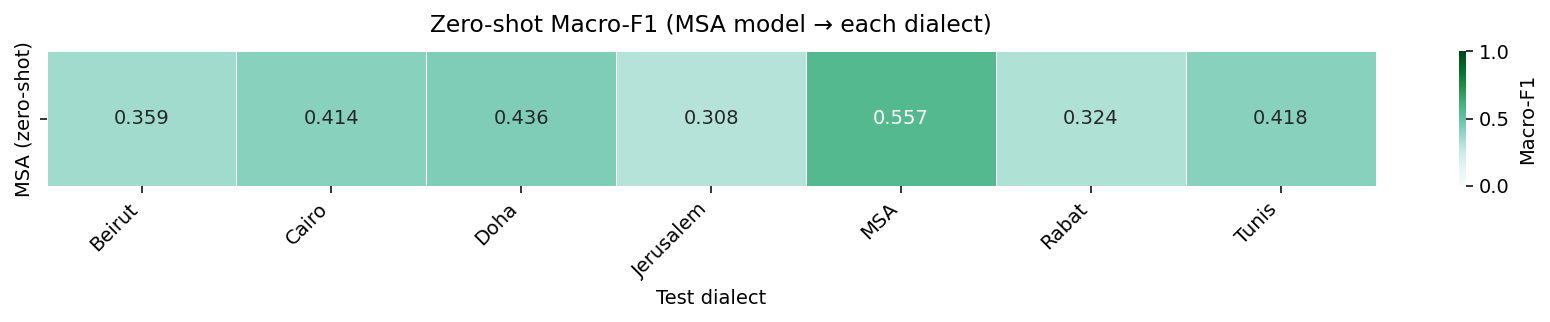

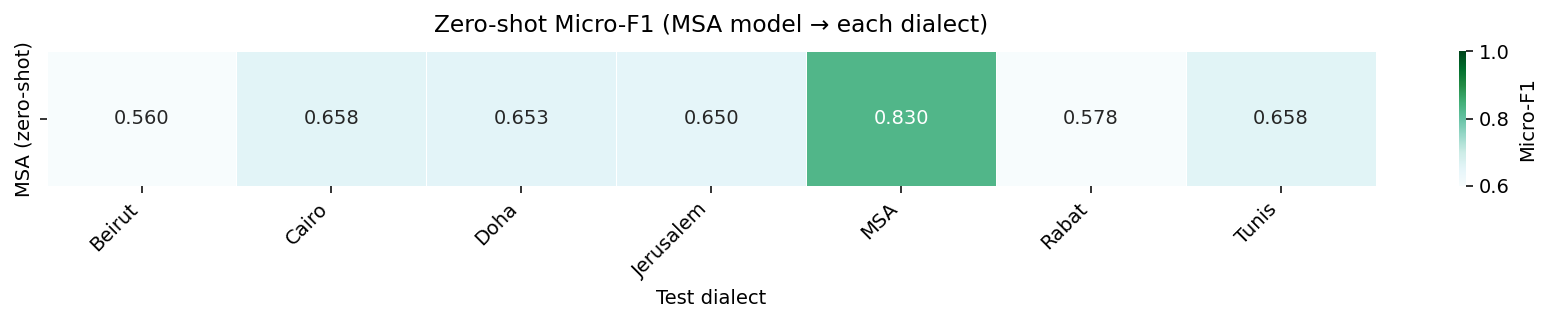

/var/folders/v9/w_hnh60x1m9fdzpm0_2cbwsc0000gn/T/ipykernel_94194/2410567145.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="pair", x="count", ax=ax, palette="Reds")


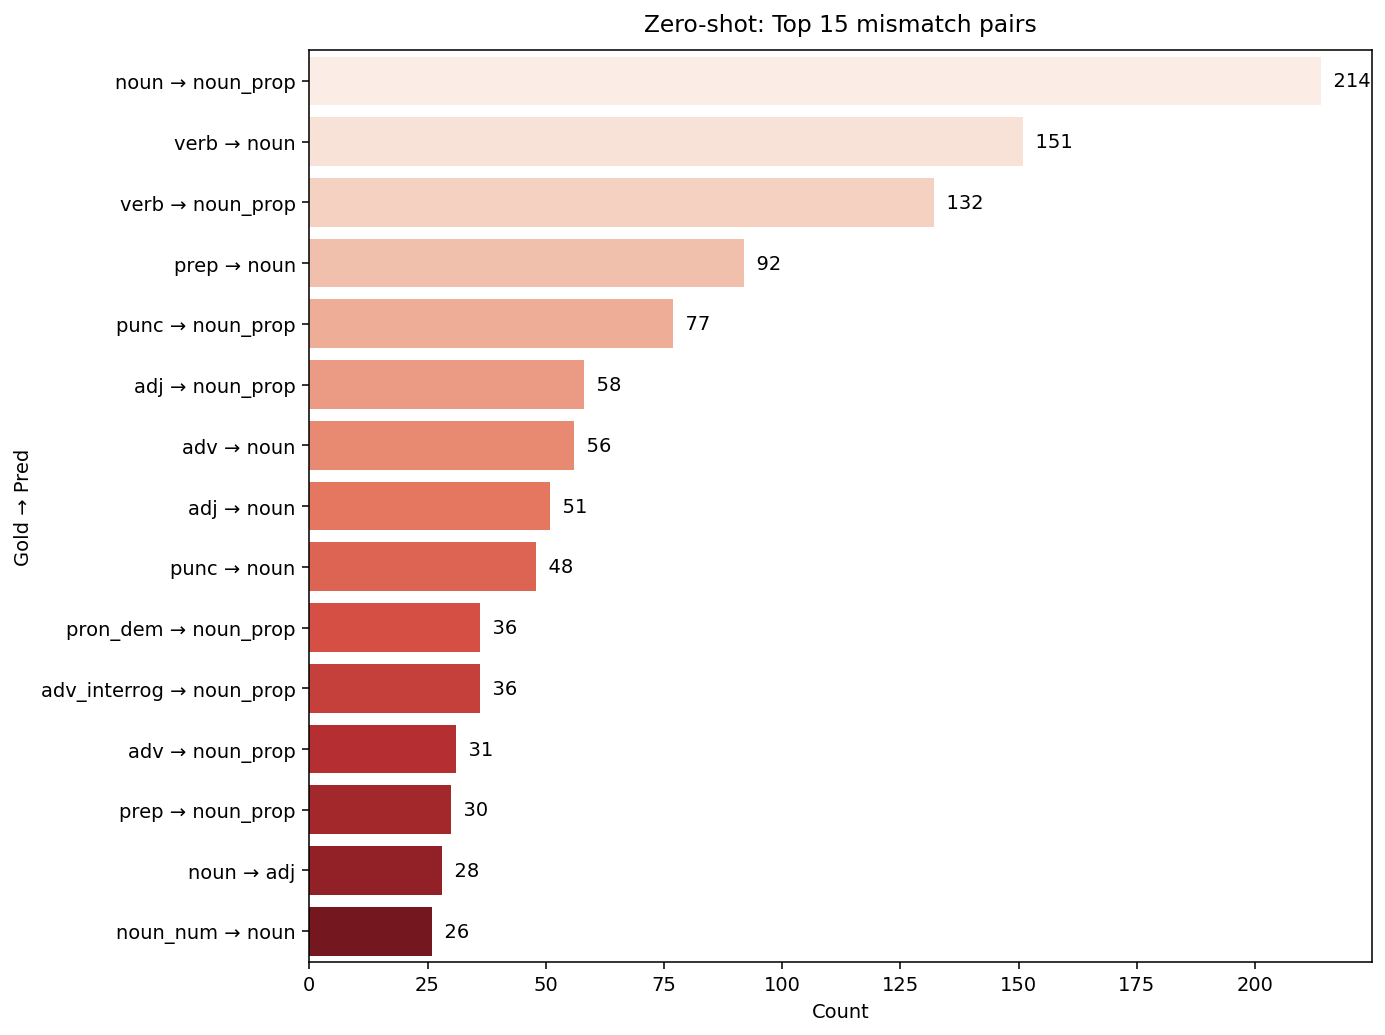

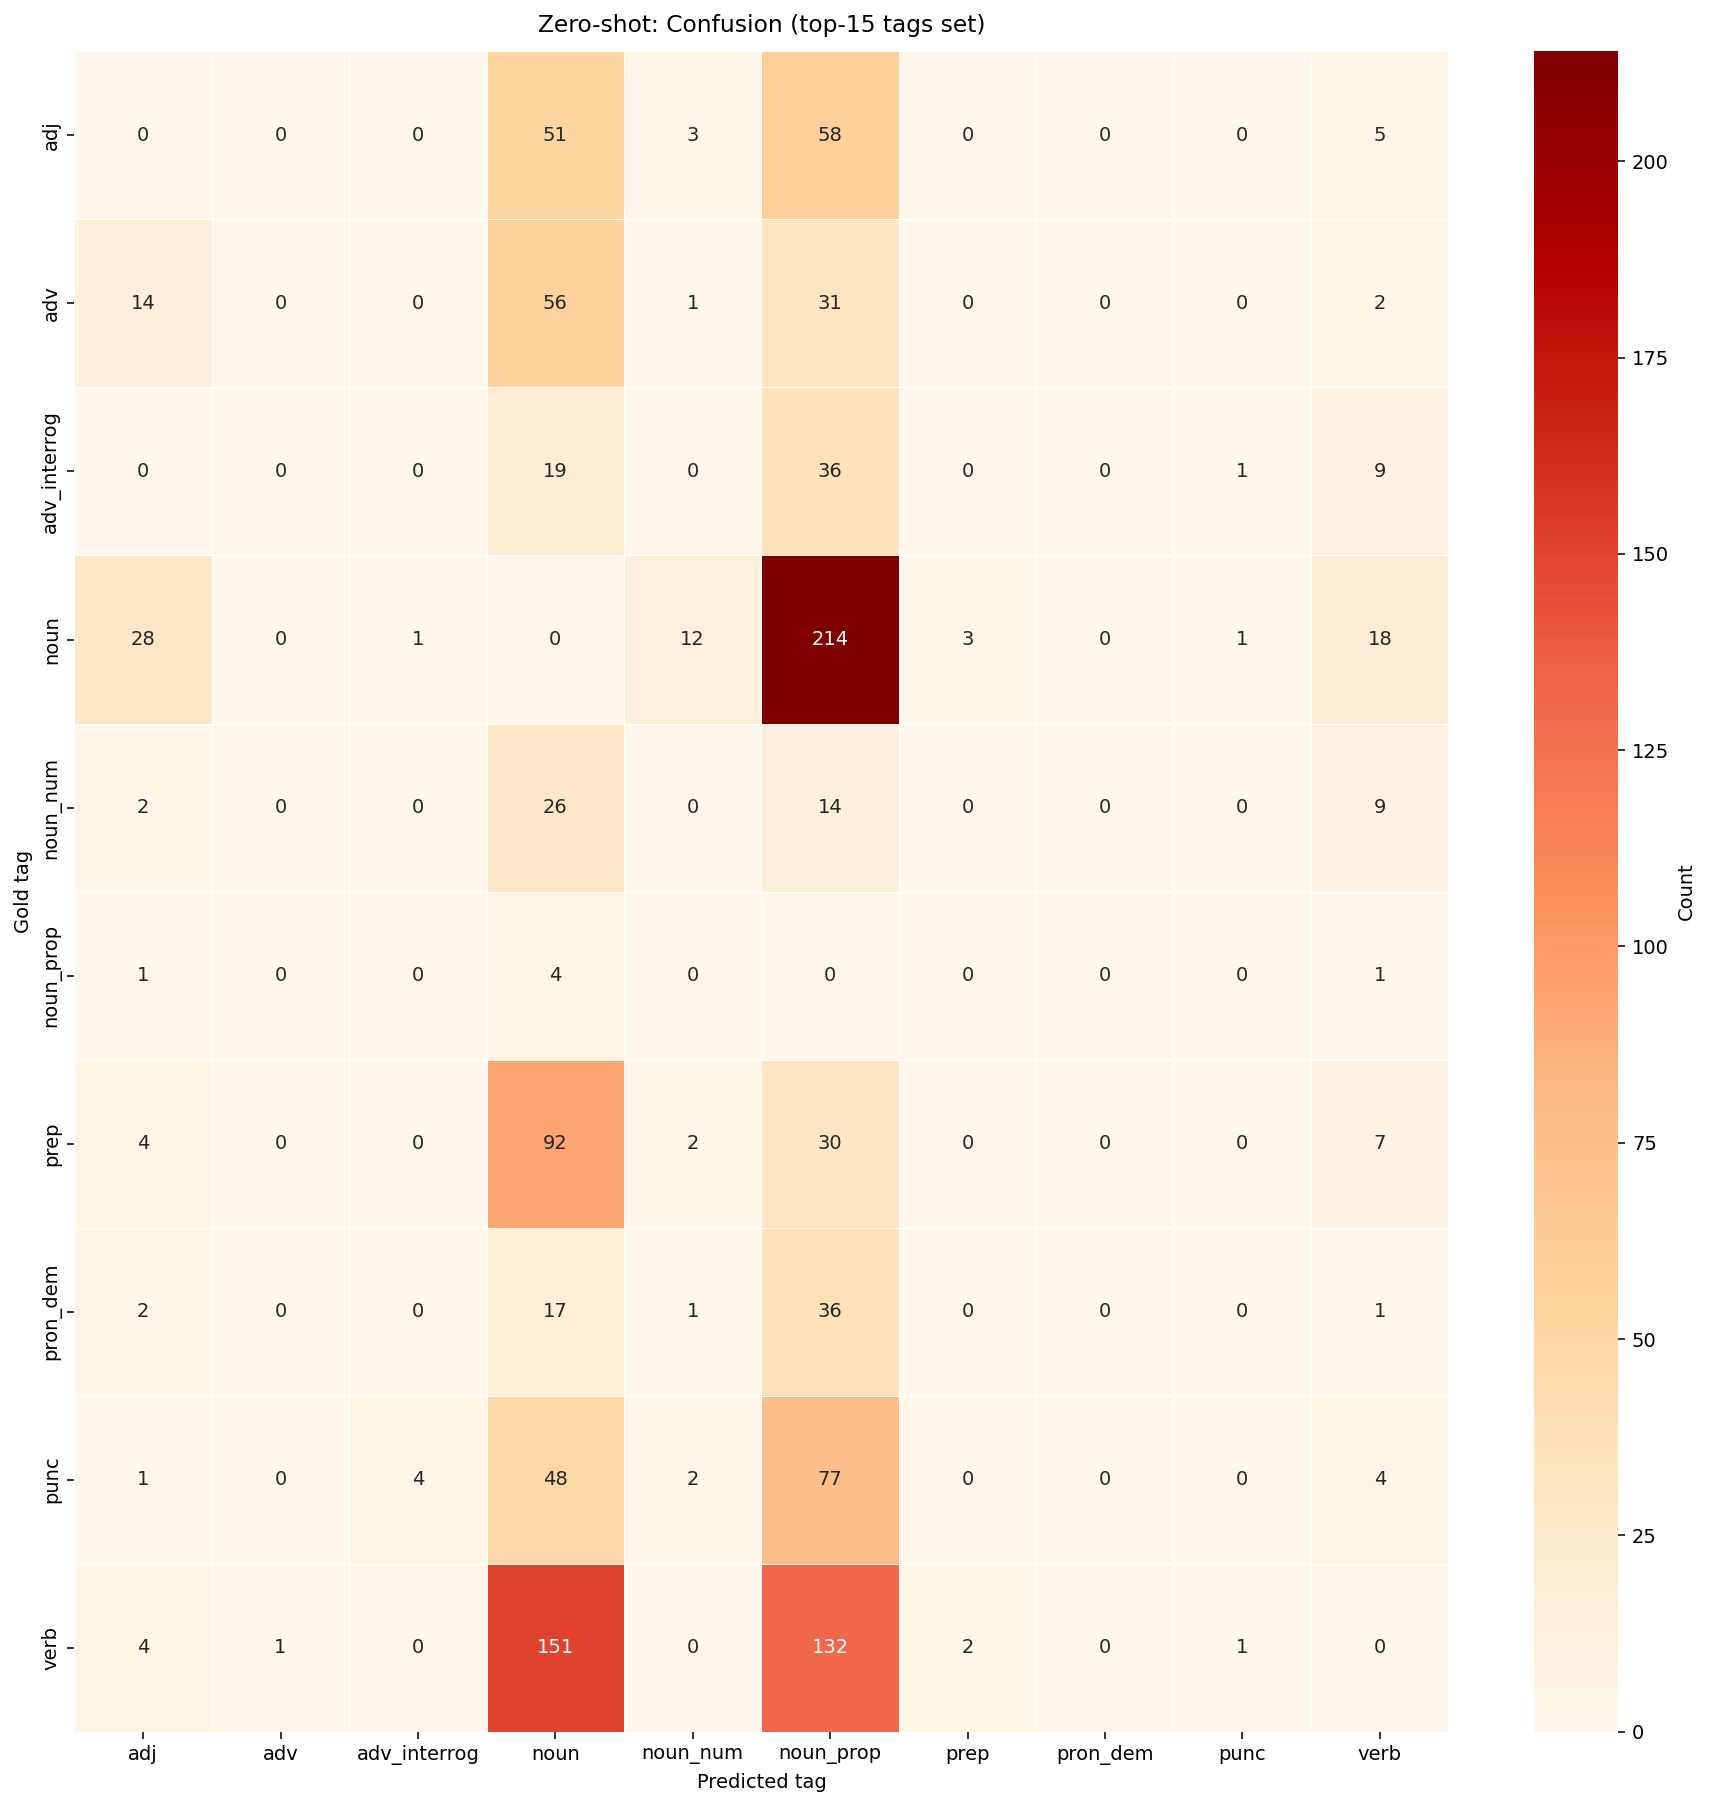

Saved: outputs/eval/zero_shot_macro_f1_heatmap.png | outputs/eval/zero_shot_micro_f1_heatmap.png


In [9]:
MODEL_ROOT = "outputs/by_dialect"
EVAL_ROOT  = "outputs/eval"
os.makedirs(EVAL_ROOT, exist_ok=True)

TOP_K = 15  # how many mismatch pairs to show per view
os.makedirs(EVAL_ROOT, exist_ok=True)

def pairs_to_df(pairs_dict, topn=TOP_K):
    """Convert {(gold,pred)->count} into a sorted DataFrame (top-N)."""
    items = sorted(pairs_dict.items(), key=lambda kv: kv[1], reverse=True)[:topn]
    rows = [{"gold": g, "pred": p, "count": c, "pair": f"{g} → {p}"} for (g, p), c in items]
    return pd.DataFrame(rows)

def plot_top_pairs_bar(df, title, outpath):
    """Horizontal bar chart for top mismatch pairs (count)."""
    if df is None or df.empty:
        print(f"(nothing to plot for {title})")
        return
    fig, ax = plt.subplots(figsize=(10, 0.5*max(4, len(df))), dpi=140)
    sns.barplot(data=df, y="pair", x="count", ax=ax, palette="Reds")
    ax.set_title(title, pad=10)
    ax.set_xlabel("Count"); ax.set_ylabel("Gold → Pred")
    for i, v in enumerate(df["count"]):
        ax.text(v, i, f"  {int(v)}", va="center")
    fig.tight_layout()
    fig.savefig(outpath, bbox_inches="tight", dpi=140)  # save BEFORE show
    plt.show(); plt.close(fig)

def plot_top_tags_heatmap(all_pairs_dict, tags_subset, title, outpath):
    """Tiny confusion-style heatmap for selected tags (gold rows, pred cols)."""
    if not tags_subset:
        return
    # build matrix for the chosen tag set
    tags = sorted(tags_subset)
    mat = pd.DataFrame(0, index=tags, columns=tags, dtype=int)
    for (g, p), c in all_pairs_dict.items():
        if g in mat.index and p in mat.columns:
            mat.loc[g, p] += c
    # if empty, skip
    if (mat.values.sum() == 0):
        return
    fig, ax = plt.subplots(figsize=(1.1*len(tags)+2, 1.1*len(tags)+2), dpi=140)
    sns.heatmap(mat, ax=ax, annot=True, fmt="d", cmap="OrRd", cbar_kws={"label":"Count"},
                linewidths=.5, linecolor="white")
    ax.set_title(title, pad=10)
    ax.set_xlabel("Predicted tag"); ax.set_ylabel("Gold tag")
    fig.tight_layout()
    fig.savefig(outpath, bbox_inches="tight", dpi=140)
    plt.show(); plt.close(fig)

dialects = sorted(dialect_dict.keys())

zs_macro = {}
zs_micro = {}
for d in dialects:
    df = zero_shot_tables.get(d)
    if df is not None and not df.empty:
        # Macro-F1: mean of per-tag F1
        zs_macro[d] = float((df["F1"] if "F1" in df.columns else df["F1 Score"]).mean())

        # Micro-F1: aggregate TP/FP/FN across tags, then compute F1
        agg = df[["TP","FP","FN"]].sum()
        tp, fp, fn = int(agg["TP"]), int(agg["FP"]), int(agg["FN"])
        p  = tp / (tp + fp) if (tp + fp) else 0.0
        r  = tp / (tp + fn) if (tp + fn) else 0.0
        f1 = (2*p*r/(p+r)) if (p+r) else 0.0
        zs_micro[d] = f1
    else:
        zs_macro[d] = 0.0
        zs_micro[d] = 0.0

# One-row matrices
zs_macro_df = pd.DataFrame([zs_macro], index=["MSA (zero-shot)"]).reindex(columns=dialects)
zs_micro_df = pd.DataFrame([zs_micro], index=["MSA (zero-shot)"]).reindex(columns=dialects)

# --- Macro-F1 heatmap ---
fig, ax = plt.subplots(figsize=(1.2*len(dialects)+4, 2.4), dpi=140)
sns.heatmap(
    zs_macro_df, ax=ax, annot=True, fmt=".3f",
    cmap="BuGn", vmin=0.0, vmax=1.0,
    linewidths=.5, linecolor="white",
    cbar_kws={"label": "Macro-F1"}
)
ax.set_title("Zero-shot Macro-F1 (MSA model → each dialect)", pad=10)
ax.set_xlabel("Test dialect"); ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
fig.tight_layout()
macro_png = os.path.join(EVAL_ROOT, "zero_shot_macro_f1_heatmap.png") if "EVAL_ROOT" in globals() else "zero_shot_macro_f1_heatmap.png"
fig.savefig(macro_png, bbox_inches="tight", dpi=140)
plt.show(); plt.close(fig)

# --- Micro-F1 heatmap (different palette + tighter low-end) ---
vmin = max(0.6, round(float(zs_micro_df.min().min()), 2)) if not zs_micro_df.empty else 0.6
fig, ax = plt.subplots(figsize=(1.2*len(dialects)+4, 2.4), dpi=140)
sns.heatmap(
    zs_micro_df, ax=ax, annot=True, fmt=".3f",
    cmap="BuGn", vmin=vmin, vmax=1.0,
    linewidths=.5, linecolor="white",
    cbar_kws={"label": "Micro-F1"}
)
ax.set_title("Zero-shot Micro-F1 (MSA model → each dialect)", pad=10)
ax.set_xlabel("Test dialect"); ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
fig.tight_layout()
micro_png = os.path.join(EVAL_ROOT, "zero_shot_micro_f1_heatmap.png") if "EVAL_ROOT" in globals() else "zero_shot_micro_f1_heatmap.png"
fig.savefig(micro_png, bbox_inches="tight", dpi=140)
plt.show(); plt.close(fig)


# ---------- zero-shot (global) ----------
sorted_dict_zero_shot = dict(sorted(mismatch_pairs.items(), key=lambda item: item[1], reverse=True))

zs_df = pairs_to_df(sorted_dict_zero_shot, TOP_K)

# Bar chart
zs_png = os.path.join(EVAL_ROOT, f"zero_shot_top{TOP_K}_mismatches_bar.png")
plot_top_pairs_bar(zs_df, f"Zero-shot: Top {TOP_K} mismatch pairs", zs_png)

# Heatmap for the tags appearing in top-K pairs
zs_tags = set(zs_df["gold"]).union(set(zs_df["pred"]))
zs_hm_png = os.path.join(EVAL_ROOT, f"zero_shot_top{TOP_K}_mismatches_heatmap.png")
plot_top_tags_heatmap(sorted_dict_zero_shot, zs_tags,
                      f"Zero-shot: Confusion (top-{TOP_K} tags set)", zs_hm_png)

print("Saved:", macro_png, "|", micro_png)


Create a global POS label map (label↔id), attach numeric label_ids to each example, and define a batched tokenizer that aligns word labels to subword tokens (with -100 masking) for training/evaluation.

In [10]:

# Build a single global label mapping (label <-> id)
all_tags = {tag for entries in dialect_dict.values() for e in entries for tag in e["pos_tags"]}
label_list = sorted(all_tags)
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# Attach numeric label_ids to each example (once)
for entries in dialect_dict.values():
    for e in entries:
        e["label_ids"] = [label2id[tag] for tag in e["pos_tags"]]

# Tokenize and align word-level labels to subword tokens (batched, robust)
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        padding=True,
        truncation=True
    )

    all_labels = []
    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        lbls = examples["label_ids"][i]
        labels = []
        prev_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)  # special/pad tokens
            elif word_idx != prev_word_idx:
                labels.append(lbls[word_idx] if word_idx < len(lbls) else -100)  # first subword gets label
            else:
                labels.append(-100)  # continuation subwords ignored
            prev_word_idx = word_idx

        all_labels.append(labels)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


Fine-tune a separate CAMeLBERT POS model for each dialect (split, tokenize/align, train with HF Trainer), then save to outputs/by_dialect/<dialect> for later cross-dialect evaluation.

In [11]:


BASE_MODEL = "CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa"  # base POS model to fine-tune per dialect
OUTPUT_ROOT = "outputs/by_dialect"
os.makedirs(OUTPUT_ROOT, exist_ok=True)  # ensure output dir exists

data_collator = DataCollatorForTokenClassification(tokenizer)  # pads batches and aligns labels properly

dialects = sorted(dialect_dict.keys())

for dialect in dialects:
    print(f"\n===== Fine-tuning model for: {dialect} =====")
    entries = dialect_dict[dialect]

    # Keep only examples where tokens and labels match in length (word-level alignment prerequisite)
    valid_entries = [e for e in entries if len(e["tokens"]) == len(e["label_ids"])]
    print(f"Using {len(valid_entries)} valid examples")
    if not valid_entries:
        print(f"Skipping {dialect}: no valid examples.")
        continue

    # Build a lightweight HF Dataset of (tokens, label_ids)
    dataset = Dataset.from_list([
        {"tokens": e["tokens"], "label_ids": e["label_ids"]}
        for e in valid_entries
    ])

    # Tokenize and align labels to subwords; drop original columns (now encoded)
    tokenized_dataset = dataset.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=dataset.column_names
    )

    # Simple train/validation split for this dialect
    ds_split = tokenized_dataset.train_test_split(test_size=0.1, seed=42)

    # Initialize a token-classification head with our label mapping
    model = AutoModelForTokenClassification.from_pretrained(
        BASE_MODEL,
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True  # tolerate minor shape diffs if any
    )

    # Training configuration (logging, batch sizes, epochs, weight decay, no external reporting)
    training_args = TrainingArguments(
        output_dir=os.path.join(OUTPUT_ROOT, dialect),
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir=f"{OUTPUT_ROOT}/logs/{dialect}",
        logging_steps=50,
        save_total_limit=1,
        report_to="none"
    )

    # Standard HF Trainer setup for token classification
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=ds_split["train"],
        eval_dataset=ds_split["test"],
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    # Fine-tune and persist the dialect-specific checkpoint
    trainer.train()
    out_dir = os.path.join(OUTPUT_ROOT, dialect)
    trainer.save_model(out_dir)
    print(f"✅ Saved fine-tuned model for {dialect} to {out_dir}")



===== Fine-tuning model for: Beirut =====
Using 100 valid examples


Map: 100%|██████████| 100/100 [00:00<00:00, 3110.53 examples/s]
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([

Step,Training Loss


✅ Saved fine-tuned model for Beirut to outputs/by_dialect/Beirut

===== Fine-tuning model for: Cairo =====
Using 100 valid examples


Map: 100%|██████████| 100/100 [00:00<00:00, 432.10 examples/s]
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3

Step,Training Loss


✅ Saved fine-tuned model for Cairo to outputs/by_dialect/Cairo

===== Fine-tuning model for: Doha =====
Using 98 valid examples


Map: 100%|██████████| 98/98 [00:00<00:00, 1687.50 examples/s]
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([32

Step,Training Loss


✅ Saved fine-tuned model for Doha to outputs/by_dialect/Doha

===== Fine-tuning model for: Jerusalem =====
Using 100 valid examples


Map: 100%|██████████| 100/100 [00:00<00:00, 751.85 examples/s]
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3

Step,Training Loss


✅ Saved fine-tuned model for Jerusalem to outputs/by_dialect/Jerusalem

===== Fine-tuning model for: MSA =====
Using 93 valid examples


Map: 100%|██████████| 93/93 [00:00<00:00, 646.75 examples/s]
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([32,

Step,Training Loss


✅ Saved fine-tuned model for MSA to outputs/by_dialect/MSA

===== Fine-tuning model for: Rabat =====
Using 97 valid examples


Map: 100%|██████████| 97/97 [00:00<00:00, 2342.44 examples/s]
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([32

Step,Training Loss


✅ Saved fine-tuned model for Rabat to outputs/by_dialect/Rabat

===== Fine-tuning model for: Tunis =====
Using 99 valid examples


Map: 100%|██████████| 99/99 [00:00<00:00, 706.25 examples/s]
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-msa and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([32,

Step,Training Loss


✅ Saved fine-tuned model for Tunis to outputs/by_dialect/Tunis


Cross-evaluate each fine-tuned dialect model on all dialect datasets, compute per-tag TP/FP/FN and macro/micro-F1, record (gold,pred) mismatches, display macro/micro-F1 matrices, and save per-pair CSVs for transfer analysis.

In [12]:
mismatch_pairs_after_finetune = defaultdict(lambda: defaultdict(int))

def safe_div(a, b):
    return a / b if b else 0.0

def predict_merge(clf_pipe, text):
    """Run pipeline, merge WordPiece sub-words → (tokens, tags)."""
    merged_tokens, merged_tags, buf, cur = [], [], "", None
    for tok in clf_pipe(text):
        w, t = tok["word"], tok["entity"]
        if w.startswith("##"):
            buf += w[2:]
        else:
            if buf:
                merged_tokens.append(buf); merged_tags.append(cur)
            buf, cur = w, t
    if buf:
        merged_tokens.append(buf); merged_tags.append(cur)
    return merged_tokens, merged_tags

def eval_on_dataset(clf_pipe, entries, mismatch_store, dialect_name):
    """Return dict[tag]->TP/FP/FN for a list of entries."""
    counts = defaultdict(lambda: {"TP":0,"FP":0,"FN":0})
    for entry in entries:
        text = entry.get("sentence") or " ".join(entry["tokens"])
        gold = entry["pos_tags"]
        _, pred = predict_merge(clf_pipe, text)

        n = min(len(gold), len(pred))
        for i in range(n):
            g, p = gold[i], pred[i]
            if g == p:
                counts[g]["TP"] += 1
            else:
                mismatch_store[dialect_name][(g, p)] += 1
                counts[g]["FN"] += 1
                counts[p]["FP"] += 1
        for g in gold[n:]: counts[g]["FN"] += 1
        for p in pred[n:]: counts[p]["FP"] += 1
    return counts

def counts_to_df(counts):
    rows = []
    for tag, c in sorted(counts.items()):
        tp, fp, fn = c["TP"], c["FP"], c["FN"]
        prec = safe_div(tp, tp + fp)
        rec  = safe_div(tp, tp + fn)
        f1   = safe_div(2*prec*rec, prec+rec) if (prec+rec) else 0.0
        rows.append({
            "POS Tag": tag, "TP": tp, "FP": fp, "FN": fn,
            "Precision": round(prec, 4), "Recall": round(rec, 4), "F1": round(f1, 4)
        })
    return pd.DataFrame(rows).set_index("POS Tag").sort_values("F1", ascending=False)

def macro_f1(df):
    return float(df["F1"].mean()) if len(df) else 0.0

def micro_f1_from_counts(counts):
    tp = sum(c["TP"] for c in counts.values())
    fp = sum(c["FP"] for c in counts.values())
    fn = sum(c["FN"] for c in counts.values())
    prec = safe_div(tp, tp + fp)
    rec  = safe_div(tp, tp + fn)
    f1   = safe_div(2*prec*rec, prec+rec) if (prec+rec) else 0.0
    return prec, rec, f1, tp, fp, fn

# ---------- evaluation ----------
device = 0 if torch.cuda.is_available() else -1

macro_f1_matrix = { }  # rows=model_dialect, cols=data_dialect
micro_f1_matrix = { }  # same shape, values = micro-F1

for model_dialect in dialects:
    model_dir = os.path.join(MODEL_ROOT, model_dialect)
    if not os.path.isdir(model_dir):
        print(f" Model for {model_dialect} not found → {model_dir}")
        continue

    print(f"\n================  MODEL = {model_dialect}  ================")
    # Use the model’s own tokenizer to avoid label mapping mismatches
    clf_pipe = pipeline("token-classification", model=model_dir, tokenizer=model_dir, device=device)

    macro_f1_matrix[model_dialect] = {}
    micro_f1_matrix[model_dialect] = {}

    for data_dialect in dialects:
        print(f"\n----  Test data = {data_dialect}  ----")
        counts = eval_on_dataset(clf_pipe, dialect_dict[data_dialect], mismatch_pairs_after_finetune, data_dialect)
        df = counts_to_df(counts)

        mF1 = macro_f1(df)
        p, r, mf1, tp, fp, fn = micro_f1_from_counts(counts)
        print(f"Macro-F1: {mF1:.3f} | Micro: P={p:.3f} R={r:.3f} F1={mf1:.3f} (TP={tp} FP={fp} FN={fn})")

        # Display/save per-tag table
        try:
            display(df)
        except Exception:
            print(df.to_string())
        df.to_csv(os.path.join(EVAL_ROOT, f"per_tag_{model_dialect}__on__{data_dialect}.csv"))

        macro_f1_matrix[model_dialect][data_dialect] = mF1
        micro_f1_matrix[model_dialect][data_dialect] = mf1

        cons = add_conservative_metrics(df[["TP","FP","FN"]])
        if cons is not None and not cons.empty:
            cons_sorted = cons.sort_values("F1_LB", ascending=False)

            # Print the best tag conservatively (penalizes tiny support + FP)
            top = cons_sorted.iloc[0]
            print(
                f"Best tag by conservative F1 (LB, excl. 'punc'): {cons_sorted.index[0]} | "
                f"F1_LB={top['F1_LB']:.3f} | Prec_LB={top['Precision_LB']:.3f} | "
                f"Rec_LB={top['Recall_LB']:.3f} | Support(rec)={int(top['Support_recall'])} | "
                f"Support(prec)={int(top['Support_precision'])}"
            )

            # Show top-5 conservatively ranked tags
            try:
                display(
                    cons_sorted.loc[:, [
                        "TP","FP","FN","Support_recall","Support_precision",
                        "Precision","Recall","Precision_LB","Recall_LB","F1_LB"
                    ]].head(5)
                     .style.format({
                         "Precision":"{:.3f}","Recall":"{:.3f}",
                         "Precision_LB":"{:.3f}","Recall_LB":"{:.3f}","F1_LB":"{:.3f}"
                     })
                     .set_caption(f"Conservative F1 (LB) — {model_dialect} → {data_dialect} (excl. 'punc')")
                )
            except Exception:
                print(
                    cons_sorted[[
                        "TP","FP","FN","Support_recall","Support_precision",
                        "Precision","Recall","Precision_LB","Recall_LB","F1_LB"
                    ]].head(10).to_string(float_format=lambda x: f"{x:.3f}")
                )

            # Save conservative table
            cons_csv = os.path.join(
                EVAL_ROOT, f"per_tag_consLB_{model_dialect}__on__{data_dialect}.csv"
            )
            cons_sorted.to_csv(cons_csv)






================  MODEL = Beirut  ================


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



----  Test data = Beirut  ----
Macro-F1: 0.426 | Micro: P=0.777 R=0.777 F1=0.777 (TP=491 FP=141 FN=141)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
part_fut,8,0,0,1.0000,1.0000,1.0000
punc,135,1,0,0.9926,1.0000,0.9963
conj_sub,10,1,2,0.9091,0.8333,0.8696
conj,12,4,0,0.7500,1.0000,0.8571
noun,172,60,9,0.7414,0.9503,0.8329
adv_interrog,8,1,4,0.8889,0.6667,0.7619
adj,27,8,11,0.7714,0.7105,0.7397
prep,21,2,17,0.9130,0.5526,0.6885
verb,86,63,23,0.5772,0.7890,0.6667


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.779 | Prec_LB=0.681 | Rec_LB=0.908 | Support(rec)=181 | Support(prec)=232


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,172,60,9,181,232,0.741,0.950,0.681,0.908,0.779
part_fut,8,0,0,8,8,1.000,1.000,0.676,0.676,0.676
conj,12,4,0,12,16,0.750,1.000,0.505,0.757,0.606
conj_sub,10,1,2,12,11,0.909,0.833,0.623,0.552,0.585
verb,86,63,23,109,149,0.577,0.789,0.497,0.703,0.582



----  Test data = Cairo  ----
Macro-F1: 0.278 | Micro: P=0.716 R=0.716 F1=0.716 (TP=479 FP=190 FN=190)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,130,3,0,0.9774,1.0000,0.9886
pron,14,0,3,1.0000,0.8235,0.9032
noun,159,65,14,0.7098,0.9191,0.8010
conj_sub,13,3,4,0.8125,0.7647,0.7879
prep,25,5,16,0.8333,0.6098,0.7042
conj,11,7,3,0.6111,0.7857,0.6875
verb,92,92,10,0.5000,0.9020,0.6434
adj,32,6,32,0.8421,0.5000,0.6275
adv_interrog,3,7,10,0.3000,0.2308,0.2609


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.742 | Prec_LB=0.647 | Rec_LB=0.869 | Support(rec)=173 | Support(prec)=224


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,159,65,14,173,224,0.710,0.919,0.647,0.869,0.742
pron,14,0,3,17,14,1.000,0.824,0.785,0.590,0.673
verb,92,92,10,102,184,0.500,0.902,0.428,0.829,0.565
conj_sub,13,3,4,17,16,0.812,0.765,0.570,0.527,0.548
prep,25,5,16,41,30,0.833,0.610,0.664,0.457,0.542



----  Test data = Doha  ----
Macro-F1: 0.295 | Micro: P=0.751 R=0.751 F1=0.751 (TP=455 FP=151 FN=151)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
pron,6,0,0,1.0000,1.0000,1.0000
punc,127,3,0,0.9769,1.0000,0.9883
conj_sub,11,1,4,0.9167,0.7333,0.8148
noun,145,58,20,0.7143,0.8788,0.7880
prep,30,2,21,0.9375,0.5882,0.7229
verb,95,63,14,0.6013,0.8716,0.7116
adj,28,9,17,0.7568,0.6222,0.6829
adv_interrog,9,3,6,0.7500,0.6000,0.6667
conj,4,9,2,0.3077,0.6667,0.4211


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.724 | Prec_LB=0.649 | Rec_LB=0.820 | Support(rec)=165 | Support(prec)=203


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,145,58,20,165,203,0.714,0.879,0.649,0.820,0.724
verb,95,63,14,109,158,0.601,0.872,0.523,0.796,0.631
pron,6,0,0,6,6,1.000,1.000,0.610,0.610,0.610
prep,30,2,21,51,32,0.938,0.588,0.799,0.452,0.577
conj_sub,11,1,4,15,12,0.917,0.733,0.646,0.480,0.551



----  Test data = Jerusalem  ----
Macro-F1: 0.361 | Micro: P=0.708 R=0.708 F1=0.708 (TP=509 FP=210 FN=210)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,149,3,0,0.9803,1.0000,0.9900
conj_sub,16,3,3,0.8421,0.8421,0.8421
pron,7,0,3,1.0000,0.7000,0.8235
noun,170,82,20,0.6746,0.8947,0.7692
prep,35,4,17,0.8974,0.6731,0.7692
part_fut,3,0,2,1.0000,0.6000,0.7500
adj,30,6,18,0.8333,0.6250,0.7143
adv_interrog,9,1,8,0.9000,0.5294,0.6667
verb,80,95,36,0.4571,0.6897,0.5498


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.711 | Prec_LB=0.615 | Rec_LB=0.843 | Support(rec)=190 | Support(prec)=252


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,170,82,20,190,252,0.675,0.895,0.615,0.843,0.711
prep,35,4,17,52,39,0.897,0.673,0.764,0.538,0.631
conj_sub,16,3,3,19,19,0.842,0.842,0.624,0.624,0.624
adj,30,6,18,48,36,0.833,0.625,0.681,0.484,0.566
pron,7,0,3,10,7,1.000,0.700,0.646,0.397,0.492



----  Test data = MSA  ----
Macro-F1: 0.251 | Micro: P=0.759 R=0.759 F1=0.759 (TP=579 FP=184 FN=184)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
pron,13,1,0,0.9286,1.0000,0.9630
punc,124,20,0,0.8611,1.0000,0.9254
noun,216,44,10,0.8308,0.9558,0.8889
verb,100,32,1,0.7576,0.9901,0.8584
prep,67,10,15,0.8701,0.8171,0.8428
adj,38,36,15,0.5135,0.7170,0.5984
adv_interrog,11,20,0,0.3548,1.0000,0.5238
conj_sub,8,4,14,0.6667,0.3636,0.4706
conj,2,12,4,0.1429,0.3333,0.2000


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.845 | Prec_LB=0.780 | Rec_LB=0.920 | Support(rec)=226 | Support(prec)=260


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,216,44,10,226,260,0.831,0.956,0.780,0.920,0.845
verb,100,32,1,101,132,0.758,0.990,0.678,0.946,0.790
prep,67,10,15,82,77,0.870,0.817,0.777,0.720,0.747
pron,13,1,0,13,14,0.929,1.000,0.685,0.772,0.726
adj,38,36,15,53,74,0.514,0.717,0.402,0.584,0.476



----  Test data = Rabat  ----
Macro-F1: 0.209 | Micro: P=0.607 R=0.607 F1=0.607 (TP=427 FP=277 FN=277)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,137,2,0,0.9856,1.0000,0.9928
conj,10,6,3,0.6250,0.7692,0.6897
noun,140,104,39,0.5738,0.7821,0.6619
adj,20,9,15,0.6897,0.5714,0.6250
pron,4,0,6,1.0000,0.4000,0.5714
verb,91,144,25,0.3872,0.7845,0.5185
prep,21,4,39,0.8400,0.3500,0.4941
adv_interrog,3,5,11,0.3750,0.2143,0.2727
conj_sub,1,2,6,0.3333,0.1429,0.2000


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.596 | Prec_LB=0.511 | Rec_LB=0.716 | Support(rec)=179 | Support(prec)=244


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,140,104,39,179,244,0.574,0.782,0.511,0.716,0.596
adj,20,9,15,35,29,0.690,0.571,0.508,0.409,0.453
verb,91,144,25,116,235,0.387,0.784,0.327,0.701,0.446
conj,10,6,3,13,16,0.625,0.769,0.386,0.497,0.435
prep,21,4,39,60,25,0.840,0.350,0.653,0.242,0.353



----  Test data = Tunis  ----
Macro-F1: 0.249 | Micro: P=0.722 R=0.723 F1=0.723 (TP=457 FP=176 FN=175)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,131,3,1,0.9776,0.9924,0.9850
pron,5,0,1,1.0000,0.8333,0.9091
noun,158,71,13,0.6900,0.9240,0.7900
conj,12,4,3,0.7500,0.8000,0.7742
verb,104,71,6,0.5943,0.9455,0.7298
prep,20,5,11,0.8000,0.6452,0.7143
adj,20,4,16,0.8333,0.5556,0.6667
conj_sub,2,3,7,0.4000,0.2222,0.2857
adv_interrog,4,13,10,0.2353,0.2857,0.2581


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.731 | Prec_LB=0.627 | Rec_LB=0.874 | Support(rec)=171 | Support(prec)=229


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,158,71,13,171,229,0.690,0.924,0.627,0.874,0.731
verb,104,71,6,110,175,0.594,0.945,0.520,0.886,0.656
prep,20,5,11,31,25,0.800,0.645,0.609,0.469,0.530
conj,12,4,3,15,16,0.750,0.800,0.505,0.548,0.526
pron,5,0,1,6,5,1.000,0.833,0.566,0.436,0.493


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



================  MODEL = Cairo  ================

----  Test data = Beirut  ----
Macro-F1: 0.295 | Micro: P=0.688 R=0.688 F1=0.688 (TP=435 FP=197 FN=197)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,135,1,0,0.9926,1.0000,0.9963
conj,11,2,1,0.8462,0.9167,0.8800
noun,156,84,25,0.6500,0.8619,0.7411
conj_sub,7,2,5,0.7778,0.5833,0.6667
prep,20,6,18,0.7692,0.5263,0.6250
verb,72,73,37,0.4966,0.6606,0.5669
adj,25,26,13,0.4902,0.6579,0.5618
pron,4,0,7,1.0000,0.3636,0.5333
adv_interrog,4,1,8,0.8000,0.3333,0.4706


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.679 | Prec_LB=0.588 | Rec_LB=0.804 | Support(rec)=181 | Support(prec)=240


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,156,84,25,181,240,0.650,0.862,0.588,0.804,0.679
conj,11,2,1,12,13,0.846,0.917,0.578,0.646,0.610
verb,72,73,37,109,145,0.497,0.661,0.416,0.568,0.480
prep,20,6,18,38,26,0.769,0.526,0.579,0.373,0.454
adj,25,26,13,38,51,0.490,0.658,0.359,0.499,0.417



----  Test data = Cairo  ----
Macro-F1: 0.368 | Micro: P=0.813 R=0.813 F1=0.813 (TP=544 FP=125 FN=125)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,130,0,0,1.0000,1.0000,1.0000
pron_dem,18,2,1,0.9000,0.9474,0.9231
conj_sub,16,2,1,0.8889,0.9412,0.9143
pron,14,0,3,1.0000,0.8235,0.9032
conj,12,2,2,0.8571,0.8571,0.8571
verb,98,34,4,0.7424,0.9608,0.8376
adj,56,14,8,0.8000,0.8750,0.8358
noun,167,63,6,0.7261,0.9653,0.8288
prep,26,5,15,0.8387,0.6341,0.7222


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.774 | Prec_LB=0.665 | Rec_LB=0.926 | Support(rec)=173 | Support(prec)=230


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,167,63,6,173,230,0.726,0.965,0.665,0.926,0.774
verb,98,34,4,102,132,0.742,0.961,0.662,0.903,0.764
adj,56,14,8,64,70,0.800,0.875,0.692,0.772,0.730
pron_dem,18,2,1,19,20,0.900,0.947,0.699,0.754,0.725
conj_sub,16,2,1,17,18,0.889,0.941,0.672,0.730,0.700



----  Test data = Doha  ----
Macro-F1: 0.306 | Micro: P=0.771 R=0.771 F1=0.771 (TP=467 FP=139 FN=139)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
pron,6,0,0,1.0000,1.0000,1.0000
punc,127,1,0,0.9922,1.0000,0.9961
conj_sub,13,0,2,1.0000,0.8667,0.9286
verb,96,35,13,0.7328,0.8807,0.8000
noun,149,76,16,0.6622,0.9030,0.7641
adj,37,18,8,0.6727,0.8222,0.7400
prep,30,5,21,0.8571,0.5882,0.6977
conj,3,1,3,0.7500,0.5000,0.6000
adv_interrog,6,2,9,0.7500,0.4000,0.5217


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.721 | Prec_LB=0.651 | Rec_LB=0.807 | Support(rec)=109 | Support(prec)=131


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,96,35,13,109,131,0.733,0.881,0.651,0.807,0.721
noun,149,76,16,165,225,0.662,0.903,0.598,0.848,0.702
conj_sub,13,0,2,15,13,1.000,0.867,0.772,0.621,0.688
pron,6,0,0,6,6,1.000,1.000,0.610,0.610,0.610
adj,37,18,8,45,55,0.673,0.822,0.541,0.687,0.605



----  Test data = Jerusalem  ----
Macro-F1: 0.341 | Micro: P=0.732 R=0.732 F1=0.732 (TP=526 FP=193 FN=193)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,149,0,0,1.0000,1.0000,1.0000
conj,10,0,1,1.0000,0.9091,0.9524
pron,8,0,2,1.0000,0.8000,0.8889
conj_sub,16,2,3,0.8889,0.8421,0.8649
prep,36,4,16,0.9000,0.6923,0.7826
noun,176,92,14,0.6567,0.9263,0.7686
adj,37,21,11,0.6379,0.7708,0.6981
verb,87,69,29,0.5577,0.7500,0.6397
adv_interrog,7,1,10,0.8750,0.4118,0.5600


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.712 | Prec_LB=0.598 | Rec_LB=0.880 | Support(rec)=190 | Support(prec)=268


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,176,92,14,190,268,0.657,0.926,0.598,0.880,0.712
conj,10,0,1,11,10,1.000,0.909,0.722,0.623,0.669
conj_sub,16,2,3,19,18,0.889,0.842,0.672,0.624,0.647
prep,36,4,16,52,40,0.900,0.692,0.769,0.557,0.646
pron,8,0,2,10,8,1.000,0.800,0.676,0.490,0.568



----  Test data = MSA  ----
Macro-F1: 0.267 | Micro: P=0.765 R=0.765 F1=0.765 (TP=584 FP=179 FN=179)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,124,4,0,0.9688,1.0000,0.9841
pron,13,1,0,0.9286,1.0000,0.9630
noun,220,60,6,0.7857,0.9735,0.8696
prep,67,11,15,0.8590,0.8171,0.8375
verb,100,54,1,0.6494,0.9901,0.7843
adj,38,15,15,0.7170,0.7170,0.7170
conj,3,0,3,1.0000,0.5000,0.6667
conj_sub,8,1,14,0.8889,0.3636,0.5161
adv_interrog,10,25,1,0.2857,0.9091,0.4348


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.826 | Prec_LB=0.734 | Rec_LB=0.943 | Support(rec)=226 | Support(prec)=280


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,220,60,6,226,280,0.786,0.973,0.734,0.943,0.826
prep,67,11,15,82,78,0.859,0.817,0.765,0.720,0.742
pron,13,1,0,13,14,0.929,1.000,0.685,0.772,0.726
verb,100,54,1,101,154,0.649,0.990,0.571,0.946,0.712
adj,38,15,15,53,53,0.717,0.717,0.584,0.584,0.584



----  Test data = Rabat  ----
Macro-F1: 0.213 | Micro: P=0.636 R=0.636 F1=0.636 (TP=448 FP=256 FN=256)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,137,1,0,0.9928,1.0000,0.9964
conj,11,1,2,0.9167,0.8462,0.8800
noun,153,120,26,0.5604,0.8547,0.6770
verb,96,96,20,0.5000,0.8276,0.6234
pron,4,0,6,1.0000,0.4000,0.5714
adj,24,33,11,0.4211,0.6857,0.5217
prep,21,4,39,0.8400,0.3500,0.4941
conj_sub,1,1,6,0.5000,0.1429,0.2222
adv_interrog,1,0,13,1.0000,0.0714,0.1333


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.615 | Prec_LB=0.501 | Rec_LB=0.796 | Support(rec)=179 | Support(prec)=273


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,153,120,26,179,273,0.560,0.855,0.501,0.796,0.615
conj,11,1,2,13,12,0.917,0.846,0.646,0.578,0.610
verb,96,96,20,116,192,0.500,0.828,0.430,0.749,0.546
adj,24,33,11,35,57,0.421,0.686,0.302,0.520,0.382
prep,21,4,39,60,25,0.840,0.350,0.653,0.242,0.353



----  Test data = Tunis  ----
Macro-F1: 0.249 | Micro: P=0.728 R=0.729 F1=0.729 (TP=461 FP=172 FN=171)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,131,2,1,0.9850,0.9924,0.9887
pron,6,1,0,0.8571,1.0000,0.9231
conj,12,1,3,0.9231,0.8000,0.8571
verb,107,57,3,0.6524,0.9727,0.7810
noun,158,83,13,0.6556,0.9240,0.7670
prep,20,4,11,0.8333,0.6452,0.7273
adj,23,21,13,0.5227,0.6389,0.5750
conj_sub,3,0,6,1.0000,0.3333,0.5000
noun_num,1,0,16,1.0000,0.0588,0.1111


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.710 | Prec_LB=0.577 | Rec_LB=0.923 | Support(rec)=110 | Support(prec)=164


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,107,57,3,110,164,0.652,0.973,0.577,0.923,0.710
noun,158,83,13,171,241,0.656,0.924,0.594,0.874,0.707
conj,12,1,3,15,13,0.923,0.800,0.667,0.548,0.602
prep,20,4,11,31,24,0.833,0.645,0.641,0.469,0.542
pron,6,1,0,6,7,0.857,1.000,0.487,0.610,0.541


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



================  MODEL = Doha  ================

----  Test data = Beirut  ----
Macro-F1: 0.280 | Micro: P=0.690 R=0.690 F1=0.690 (TP=436 FP=196 FN=196)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,135,11,0,0.9247,1.0000,0.9609
noun,163,100,18,0.6198,0.9006,0.7342
adv_interrog,8,2,4,0.8000,0.6667,0.7273
conj_sub,7,1,5,0.8750,0.5833,0.7000
adj,25,10,13,0.7143,0.6579,0.6849
prep,20,7,18,0.7407,0.5263,0.6154
verb,71,64,38,0.5259,0.6514,0.5820
noun_num,5,1,7,0.8333,0.4167,0.5556
pron,1,0,10,1.0000,0.0909,0.1667


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.674 | Prec_LB=0.560 | Rec_LB=0.848 | Support(rec)=181 | Support(prec)=263


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,163,100,18,181,263,0.620,0.901,0.560,0.848,0.674
adj,25,10,13,38,35,0.714,0.658,0.549,0.499,0.523
verb,71,64,38,109,135,0.526,0.651,0.442,0.558,0.493
prep,20,7,18,38,27,0.741,0.526,0.553,0.373,0.445
adv_interrog,8,2,4,12,10,0.800,0.667,0.490,0.391,0.435



----  Test data = Cairo  ----
Macro-F1: 0.264 | Micro: P=0.720 R=0.720 F1=0.720 (TP=482 FP=187 FN=187)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,130,8,0,0.9420,1.0000,0.9701
conj_sub,14,2,3,0.8750,0.8235,0.8485
noun,161,89,12,0.6440,0.9306,0.7612
adj,42,6,22,0.8750,0.6562,0.7500
verb,92,63,10,0.5935,0.9020,0.7160
prep,26,11,15,0.7027,0.6341,0.6667
adv_interrog,6,4,7,0.6000,0.4615,0.5217
pron,5,0,12,1.0000,0.2941,0.4545
noun_num,4,3,9,0.5714,0.3077,0.4000


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.702 | Prec_LB=0.583 | Rec_LB=0.883 | Support(rec)=173 | Support(prec)=250


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,161,89,12,173,250,0.644,0.931,0.583,0.883,0.702
verb,92,63,10,102,155,0.594,0.902,0.515,0.829,0.635
adj,42,6,22,64,48,0.875,0.656,0.753,0.534,0.625
conj_sub,14,2,3,17,16,0.875,0.824,0.640,0.590,0.614
prep,26,11,15,41,37,0.703,0.634,0.542,0.481,0.510



----  Test data = Doha  ----
Macro-F1: 0.338 | Micro: P=0.827 R=0.827 F1=0.827 (TP=501 FP=105 FN=105)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,127,4,0,0.9695,1.0000,0.9845
conj_sub,13,0,2,1.0000,0.8667,0.9286
verb,107,23,2,0.8231,0.9817,0.8954
adj,39,7,6,0.8478,0.8667,0.8571
noun,161,57,4,0.7385,0.9758,0.8407
noun_num,10,0,5,1.0000,0.6667,0.8000
prep,31,7,20,0.8158,0.6078,0.6966
adv_interrog,10,6,5,0.6250,0.6667,0.6452
pron,2,0,4,1.0000,0.3333,0.5000


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.832 | Prec_LB=0.748 | Rec_LB=0.936 | Support(rec)=109 | Support(prec)=130


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,107,23,2,109,130,0.823,0.982,0.748,0.936,0.832
noun,161,57,4,165,218,0.739,0.976,0.676,0.939,0.786
adj,39,7,6,45,46,0.848,0.867,0.718,0.738,0.728
conj_sub,13,0,2,15,13,1.000,0.867,0.772,0.621,0.688
prep,31,7,20,51,38,0.816,0.608,0.666,0.471,0.552



----  Test data = Jerusalem  ----
Macro-F1: 0.292 | Micro: P=0.729 R=0.729 F1=0.729 (TP=524 FP=195 FN=195)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,149,9,0,0.9430,1.0000,0.9707
conj_sub,15,2,4,0.8824,0.7895,0.8333
prep,36,5,16,0.8780,0.6923,0.7742
noun,179,100,11,0.6416,0.9421,0.7633
adj,31,9,17,0.7750,0.6458,0.7045
verb,92,62,24,0.5974,0.7931,0.6815
noun_num,12,3,11,0.8000,0.5217,0.6316
adv_interrog,9,4,8,0.6923,0.5294,0.6000
conj,1,0,10,1.0000,0.0909,0.1667


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.708 | Prec_LB=0.584 | Rec_LB=0.899 | Support(rec)=190 | Support(prec)=279


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,179,100,11,190,279,0.642,0.942,0.584,0.899,0.708
prep,36,5,16,52,41,0.878,0.692,0.745,0.557,0.637
conj_sub,15,2,4,19,17,0.882,0.789,0.657,0.567,0.608
verb,92,62,24,116,154,0.597,0.793,0.518,0.711,0.600
adj,31,9,17,48,40,0.775,0.646,0.625,0.504,0.558



----  Test data = MSA  ----
Macro-F1: 0.229 | Micro: P=0.752 R=0.752 F1=0.752 (TP=574 FP=189 FN=189)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,124,7,0,0.9466,1.0000,0.9725
noun,217,59,9,0.7862,0.9602,0.8645
prep,67,16,15,0.8072,0.8171,0.8121
verb,100,54,1,0.6494,0.9901,0.7843
noun_num,9,4,2,0.6923,0.8182,0.7500
adj,37,9,16,0.8043,0.6981,0.7475
conj_sub,8,3,14,0.7273,0.3636,0.4848
adv_interrog,11,33,0,0.2500,1.0000,0.4000
pron,1,0,12,1.0000,0.0769,0.1429


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.819 | Prec_LB=0.734 | Rec_LB=0.926 | Support(rec)=226 | Support(prec)=276


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,217,59,9,226,276,0.786,0.960,0.734,0.926,0.819
prep,67,16,15,82,83,0.807,0.817,0.710,0.720,0.715
verb,100,54,1,101,154,0.649,0.990,0.571,0.946,0.712
adj,37,9,16,53,46,0.804,0.698,0.668,0.565,0.612
noun_num,9,4,2,11,13,0.692,0.818,0.424,0.523,0.468



----  Test data = Rabat  ----
Macro-F1: 0.182 | Micro: P=0.636 R=0.636 F1=0.636 (TP=448 FP=256 FN=256)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,137,10,0,0.9320,1.0000,0.9648
verb,95,72,21,0.5689,0.8190,0.6714
adj,24,13,11,0.6486,0.6857,0.6667
noun,164,153,15,0.5174,0.9162,0.6613
prep,21,5,39,0.8077,0.3500,0.4884
adv_interrog,4,1,10,0.8000,0.2857,0.4211
conj_sub,1,2,6,0.3333,0.1429,0.2000
conj,1,0,12,1.0000,0.0769,0.1429
noun_num,1,0,12,1.0000,0.0769,0.1429


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.603 | Prec_LB=0.462 | Rec_LB=0.866 | Support(rec)=179 | Support(prec)=317


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,164,153,15,179,317,0.517,0.916,0.462,0.866,0.603
verb,95,72,21,116,167,0.569,0.819,0.493,0.739,0.591
adj,24,13,11,35,37,0.649,0.686,0.488,0.520,0.503
prep,21,5,39,60,26,0.808,0.350,0.621,0.242,0.348
adv_interrog,4,1,10,14,5,0.800,0.286,0.376,0.117,0.179



----  Test data = Tunis  ----
Macro-F1: 0.209 | Micro: P=0.717 R=0.718 F1=0.718 (TP=454 FP=179 FN=178)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,131,14,1,0.9034,0.9924,0.9458
verb,104,46,6,0.6933,0.9455,0.8000
noun,162,100,9,0.6183,0.9474,0.7483
adj,25,8,11,0.7576,0.6944,0.7246
prep,20,5,11,0.8000,0.6452,0.7143
conj_sub,3,0,6,1.0000,0.3333,0.5000
noun_num,5,0,12,1.0000,0.2941,0.4545
adv_interrog,4,6,10,0.4000,0.2857,0.3333
abbrev,0,0,1,0.0000,0.0000,0.0000


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.726 | Prec_LB=0.615 | Rec_LB=0.886 | Support(rec)=110 | Support(prec)=150


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,104,46,6,110,150,0.693,0.945,0.615,0.886,0.726
noun,162,100,9,171,262,0.618,0.947,0.558,0.903,0.690
adj,25,8,11,36,33,0.758,0.694,0.590,0.531,0.559
prep,20,5,11,31,25,0.800,0.645,0.609,0.469,0.530
noun_num,5,0,12,17,5,1.000,0.294,0.566,0.133,0.215


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



================  MODEL = Jerusalem  ================

----  Test data = Beirut  ----
Macro-F1: 0.356 | Micro: P=0.709 R=0.709 F1=0.709 (TP=448 FP=184 FN=184)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,135,1,0,0.9926,1.0000,0.9963
conj,11,1,1,0.9167,0.9167,0.9167
noun,155,86,26,0.6432,0.8564,0.7346
conj_sub,7,1,5,0.8750,0.5833,0.7000
adv_interrog,8,5,4,0.6154,0.6667,0.6400
verb,77,61,32,0.5580,0.7064,0.6235
adj,23,13,15,0.6389,0.6053,0.6216
prep,21,13,17,0.6176,0.5526,0.5833
noun_num,5,1,7,0.8333,0.4167,0.5556


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.672 | Prec_LB=0.581 | Rec_LB=0.798 | Support(rec)=181 | Support(prec)=241


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,155,86,26,181,241,0.643,0.856,0.581,0.798,0.672
conj,11,1,1,12,12,0.917,0.917,0.646,0.646,0.646
verb,77,61,32,109,138,0.558,0.706,0.475,0.615,0.536
adj,23,13,15,38,36,0.639,0.605,0.476,0.447,0.461
prep,21,13,17,38,34,0.618,0.553,0.450,0.397,0.422



----  Test data = Cairo  ----
Macro-F1: 0.328 | Micro: P=0.728 R=0.728 F1=0.728 (TP=487 FP=182 FN=182)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,130,0,0,1.0000,1.0000,1.0000
conj,11,0,3,1.0000,0.7857,0.8800
conj_sub,13,1,4,0.9286,0.7647,0.8387
noun,155,87,18,0.6405,0.8960,0.7470
adj,42,8,22,0.8400,0.6562,0.7368
verb,89,62,13,0.5894,0.8725,0.7036
pron,9,0,8,1.0000,0.5294,0.6923
prep,26,11,15,0.7027,0.6341,0.6667
adv_interrog,6,7,7,0.4615,0.4615,0.4615


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.685 | Prec_LB=0.578 | Rec_LB=0.842 | Support(rec)=173 | Support(prec)=242


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,155,87,18,173,242,0.640,0.896,0.578,0.842,0.685
verb,89,62,13,102,151,0.589,0.873,0.510,0.794,0.621
conj,11,0,3,14,11,1.000,0.786,0.741,0.524,0.614
adj,42,8,22,64,50,0.840,0.656,0.715,0.534,0.611
conj_sub,13,1,4,17,14,0.929,0.765,0.685,0.527,0.596



----  Test data = Doha  ----
Macro-F1: 0.297 | Micro: P=0.762 R=0.762 F1=0.762 (TP=462 FP=144 FN=144)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,127,2,0,0.9845,1.0000,0.9922
conj_sub,10,0,5,1.0000,0.6667,0.8000
verb,96,43,13,0.6906,0.8807,0.7742
noun,148,74,17,0.6667,0.8970,0.7649
adj,31,6,14,0.8378,0.6889,0.7561
noun_num,9,2,6,0.8182,0.6000,0.6923
prep,31,10,20,0.7561,0.6078,0.6739
adv_interrog,8,5,7,0.6154,0.5333,0.5714
conj,2,0,4,1.0000,0.3333,0.5000


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.702 | Prec_LB=0.602 | Rec_LB=0.841 | Support(rec)=165 | Support(prec)=222


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,148,74,17,165,222,0.667,0.897,0.602,0.841,0.702
verb,96,43,13,109,139,0.691,0.881,0.610,0.807,0.694
adj,31,6,14,45,37,0.838,0.689,0.689,0.543,0.607
prep,31,10,20,51,41,0.756,0.608,0.607,0.471,0.530
conj_sub,10,0,5,15,10,1.000,0.667,0.722,0.417,0.529



----  Test data = Jerusalem  ----
Macro-F1: 0.475 | Micro: P=0.819 R=0.819 F1=0.819 (TP=589 FP=130 FN=130)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,149,0,0,1.0000,1.0000,1.0000
conj,10,0,1,1.0000,0.9091,0.9524
conj_sub,18,2,1,0.9000,0.9474,0.9231
noun,184,56,6,0.7667,0.9684,0.8558
prep,43,10,9,0.8113,0.8269,0.8190
adj,39,9,9,0.8125,0.8125,0.8125
verb,106,43,10,0.7114,0.9138,0.8000
part_fut,3,0,2,1.0000,0.6000,0.7500
adv_interrog,13,6,4,0.6842,0.7647,0.7222


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.806 | Prec_LB=0.709 | Rec_LB=0.933 | Support(rec)=190 | Support(prec)=240


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,184,56,6,190,240,0.767,0.968,0.709,0.933,0.806
verb,106,43,10,116,149,0.711,0.914,0.634,0.849,0.726
conj_sub,18,2,1,19,20,0.900,0.947,0.699,0.754,0.725
prep,43,10,9,52,53,0.811,0.827,0.686,0.703,0.694
adj,39,9,9,48,48,0.812,0.812,0.681,0.681,0.681



----  Test data = MSA  ----
Macro-F1: 0.275 | Micro: P=0.767 R=0.767 F1=0.767 (TP=585 FP=178 FN=178)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,124,6,0,0.9538,1.0000,0.9764
noun,216,61,10,0.7798,0.9558,0.8588
verb,100,39,1,0.7194,0.9901,0.8333
prep,67,18,15,0.7882,0.8171,0.8024
adj,38,7,15,0.8444,0.7170,0.7755
noun_num,10,5,1,0.6667,0.9091,0.7692
conj_sub,12,1,10,0.9231,0.5455,0.6857
conj,3,1,3,0.7500,0.5000,0.6000
pron,4,0,9,1.0000,0.3077,0.4706


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.813 | Prec_LB=0.727 | Rec_LB=0.920 | Support(rec)=226 | Support(prec)=277


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,216,61,10,226,277,0.780,0.956,0.727,0.920,0.813
verb,100,39,1,101,139,0.719,0.990,0.640,0.946,0.763
prep,67,18,15,82,85,0.788,0.817,0.690,0.720,0.705
adj,38,7,15,53,45,0.844,0.717,0.712,0.584,0.642
noun_num,10,5,1,11,15,0.667,0.909,0.417,0.623,0.500



----  Test data = Rabat  ----
Macro-F1: 0.229 | Micro: P=0.642 R=0.642 F1=0.642 (TP=452 FP=252 FN=252)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,137,1,0,0.9928,1.0000,0.9964
conj,11,0,2,1.0000,0.8462,0.9167
noun,149,123,30,0.5478,0.8324,0.6608
adj,25,16,10,0.6098,0.7143,0.6579
verb,98,85,18,0.5355,0.8448,0.6555
prep,23,16,37,0.5897,0.3833,0.4646
adv_interrog,6,8,8,0.4286,0.4286,0.4286
part_neg,1,1,3,0.5000,0.2500,0.3333
conj_sub,1,0,6,1.0000,0.1429,0.2500


Best tag by conservative F1 (LB, excl. 'punc'): conj | F1_LB=0.649 | Prec_LB=0.741 | Rec_LB=0.578 | Support(rec)=13 | Support(prec)=11


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
conj,11,0,2,13,11,1.000,0.846,0.741,0.578,0.649
noun,149,123,30,179,272,0.548,0.832,0.488,0.771,0.598
verb,98,85,18,116,183,0.536,0.845,0.463,0.768,0.578
adj,25,16,10,35,41,0.610,0.714,0.457,0.549,0.499
prep,23,16,37,60,39,0.590,0.383,0.434,0.271,0.334



----  Test data = Tunis  ----
Macro-F1: 0.280 | Micro: P=0.747 R=0.748 F1=0.748 (TP=473 FP=160 FN=159)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,131,2,1,0.9850,0.9924,0.9887
conj,12,0,3,1.0000,0.8000,0.8889
verb,108,44,2,0.7105,0.9818,0.8244
noun,159,85,12,0.6516,0.9298,0.7663
prep,20,6,11,0.7692,0.6452,0.7018
adj,25,13,11,0.6579,0.6944,0.6757
noun_num,7,0,10,1.0000,0.4118,0.5833
conj_sub,3,0,6,1.0000,0.3333,0.5000
part_neg,2,0,5,1.0000,0.2857,0.4444


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.756 | Prec_LB=0.634 | Rec_LB=0.936 | Support(rec)=110 | Support(prec)=152


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,108,44,2,110,152,0.711,0.982,0.634,0.936,0.756
noun,159,85,12,171,244,0.652,0.930,0.590,0.881,0.707
conj,12,0,3,15,12,1.000,0.800,0.757,0.548,0.636
prep,20,6,11,31,26,0.769,0.645,0.579,0.469,0.519
adj,25,13,11,36,38,0.658,0.694,0.499,0.531,0.515


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



================  MODEL = MSA  ================

----  Test data = Beirut  ----
Macro-F1: 0.322 | Micro: P=0.668 R=0.668 F1=0.668 (TP=422 FP=210 FN=210)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,135,5,0,0.9643,1.0000,0.9818
noun,162,117,19,0.5806,0.8950,0.7043
conj,7,1,5,0.8750,0.5833,0.7000
conj_sub,6,1,6,0.8571,0.5000,0.6316
pron,5,0,6,1.0000,0.4545,0.6250
adj,25,20,13,0.5556,0.6579,0.6024
adv_interrog,5,0,7,1.0000,0.4167,0.5882
prep,22,19,16,0.5366,0.5789,0.5570
noun_num,5,1,7,0.8333,0.4167,0.5556


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.644 | Prec_LB=0.522 | Rec_LB=0.842 | Support(rec)=181 | Support(prec)=279


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,162,117,19,181,279,0.581,0.895,0.522,0.842,0.644
adj,25,20,13,38,45,0.556,0.658,0.412,0.499,0.451
prep,22,19,16,38,41,0.537,0.579,0.387,0.422,0.404
conj,7,1,5,12,8,0.875,0.583,0.529,0.320,0.398
verb,49,43,60,109,92,0.533,0.450,0.431,0.359,0.392



----  Test data = Cairo  ----
Macro-F1: 0.284 | Micro: P=0.728 R=0.728 F1=0.728 (TP=487 FP=182 FN=182)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,130,0,0,1.0000,1.0000,1.0000
pron,15,0,2,1.0000,0.8824,0.9375
conj,11,0,3,1.0000,0.7857,0.8800
conj_sub,14,2,3,0.8750,0.8235,0.8485
noun,163,96,10,0.6293,0.9422,0.7546
verb,83,39,19,0.6803,0.8137,0.7411
adj,42,13,22,0.7636,0.6562,0.7059
prep,26,20,15,0.5652,0.6341,0.5977
noun_num,2,3,11,0.4000,0.1538,0.2222


Best tag by conservative F1 (LB, excl. 'punc'): pron | F1_LB=0.720 | Prec_LB=0.796 | Rec_LB=0.657 | Support(rec)=17 | Support(prec)=15


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
pron,15,0,2,17,15,1.000,0.882,0.796,0.657,0.720
noun,163,96,10,173,259,0.629,0.942,0.569,0.897,0.696
verb,83,39,19,102,122,0.680,0.814,0.593,0.727,0.653
conj,11,0,3,14,11,1.000,0.786,0.741,0.524,0.614
conj_sub,14,2,3,17,16,0.875,0.824,0.640,0.590,0.614



----  Test data = Doha  ----
Macro-F1: 0.376 | Micro: P=0.772 R=0.772 F1=0.772 (TP=468 FP=138 FN=138)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
pron,6,0,0,1.0000,1.0000,1.0000
punc,127,1,0,0.9922,1.0000,0.9961
pron_dem,3,0,1,1.0000,0.7500,0.8571
verb,86,19,23,0.8190,0.7890,0.8037
conj_sub,10,0,5,1.0000,0.6667,0.8000
adj,36,14,9,0.7200,0.8000,0.7579
noun,152,85,13,0.6414,0.9212,0.7562
noun_num,8,0,7,1.0000,0.5333,0.6957
prep,33,15,18,0.6875,0.6471,0.6667


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.719 | Prec_LB=0.735 | Rec_LB=0.703 | Support(rec)=109 | Support(prec)=105


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,86,19,23,109,105,0.819,0.789,0.735,0.703,0.719
noun,152,85,13,165,237,0.641,0.921,0.578,0.870,0.695
adj,36,14,9,45,50,0.720,0.800,0.583,0.662,0.620
pron,6,0,0,6,6,1.000,1.000,0.610,0.610,0.610
conj_sub,10,0,5,15,10,1.000,0.667,0.722,0.417,0.529



----  Test data = Jerusalem  ----
Macro-F1: 0.345 | Micro: P=0.697 R=0.697 F1=0.697 (TP=501 FP=218 FN=218)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,149,4,0,0.9739,1.0000,0.9868
pron,8,0,2,1.0000,0.8000,0.8889
conj_sub,14,2,5,0.8750,0.7368,0.8000
prep,36,12,16,0.7500,0.6923,0.7200
noun,176,131,14,0.5733,0.9263,0.7082
conj,6,0,5,1.0000,0.5455,0.7059
adj,35,19,13,0.6481,0.7292,0.6863
noun_num,11,1,12,0.9167,0.4783,0.6286
adv_interrog,7,0,10,1.0000,0.4118,0.5833


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.652 | Prec_LB=0.517 | Rec_LB=0.880 | Support(rec)=190 | Support(prec)=307


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,176,131,14,190,307,0.573,0.926,0.517,0.880,0.652
prep,36,12,16,52,48,0.750,0.692,0.612,0.557,0.583
conj_sub,14,2,5,19,16,0.875,0.737,0.640,0.512,0.569
pron,8,0,2,10,8,1.000,0.800,0.676,0.490,0.568
adj,35,19,13,48,54,0.648,0.729,0.515,0.590,0.550



----  Test data = MSA  ----
Macro-F1: 0.474 | Micro: P=0.874 R=0.874 F1=0.874 (TP=667 FP=96 FN=96)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
pron,13,0,0,1.0000,1.0000,1.0000
part_interrog,24,0,0,1.0000,1.0000,1.0000
punc,124,5,0,0.9612,1.0000,0.9802
verb,101,13,0,0.8860,1.0000,0.9395
noun,220,38,6,0.8527,0.9735,0.9091
conj_sub,19,1,3,0.9500,0.8636,0.9048
adj,44,3,9,0.9362,0.8302,0.8800
adv_interrog,11,3,0,0.7857,1.0000,0.8800
pron_dem,21,7,1,0.7500,0.9545,0.8400


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.883 | Prec_LB=0.815 | Rec_LB=0.963 | Support(rec)=101 | Support(prec)=114


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,101,13,0,101,114,0.886,1.000,0.815,0.963,0.883
noun,220,38,6,226,258,0.853,0.973,0.804,0.943,0.868
part_interrog,24,0,0,24,24,1.000,1.000,0.862,0.862,0.862
pron,13,0,0,13,13,1.000,1.000,0.772,0.772,0.772
adj,44,3,9,53,47,0.936,0.830,0.828,0.708,0.763



----  Test data = Rabat  ----
Macro-F1: 0.237 | Micro: P=0.639 R=0.639 F1=0.639 (TP=450 FP=254 FN=254)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,137,4,0,0.9716,1.0000,0.9856
conj,7,0,6,1.0000,0.5385,0.7000
verb,82,37,34,0.6891,0.7069,0.6979
noun,161,164,18,0.4954,0.8994,0.6389
adj,25,26,10,0.4902,0.7143,0.5814
pron,4,0,6,1.0000,0.4000,0.5714
prep,25,18,35,0.5814,0.4167,0.4854
pron_dem,5,3,11,0.6250,0.3125,0.4167
adv_interrog,2,0,12,1.0000,0.1429,0.2500


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.610 | Prec_LB=0.601 | Rec_LB=0.618 | Support(rec)=116 | Support(prec)=119


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,82,37,34,116,119,0.689,0.707,0.601,0.618,0.610
noun,161,164,18,179,325,0.495,0.899,0.441,0.847,0.580
adj,25,26,10,35,51,0.490,0.714,0.359,0.549,0.434
conj,7,0,6,13,7,1.000,0.538,0.646,0.291,0.402
prep,25,18,35,60,43,0.581,0.417,0.433,0.301,0.355



----  Test data = Tunis  ----
Macro-F1: 0.275 | Micro: P=0.738 R=0.739 F1=0.738 (TP=467 FP=166 FN=165)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
pron,6,0,0,1.0000,1.0000,1.0000
punc,131,7,1,0.9493,0.9924,0.9704
verb,98,28,12,0.7778,0.8909,0.8305
noun,160,95,11,0.6275,0.9357,0.7512
pron_dem,11,0,8,1.0000,0.5789,0.7333
adj,27,19,9,0.5870,0.7500,0.6585
prep,20,11,11,0.6452,0.6452,0.6452
conj,5,0,10,1.0000,0.3333,0.5000
noun_num,4,0,13,1.0000,0.2353,0.3810


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.753 | Prec_LB=0.698 | Rec_LB=0.819 | Support(rec)=110 | Support(prec)=126


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,98,28,12,110,126,0.778,0.891,0.698,0.819,0.753
noun,160,95,11,171,255,0.627,0.936,0.567,0.888,0.692
pron,6,0,0,6,6,1.000,1.000,0.610,0.610,0.610
adj,27,19,9,36,46,0.587,0.750,0.443,0.589,0.506
pron_dem,11,0,8,19,11,1.000,0.579,0.741,0.363,0.487


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



================  MODEL = Rabat  ================

----  Test data = Beirut  ----
Macro-F1: 0.228 | Micro: P=0.676 R=0.676 F1=0.676 (TP=427 FP=205 FN=205)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,135,0,0,1.0000,1.0000,1.0000
conj,11,1,1,0.9167,0.9167,0.9167
noun,159,93,22,0.6310,0.8785,0.7344
adv_interrog,6,0,6,1.0000,0.5000,0.6667
verb,76,77,33,0.4967,0.6972,0.5802
prep,21,14,17,0.6000,0.5526,0.5753
adj,18,9,20,0.6667,0.4737,0.5538
part_interrog,1,2,5,0.3333,0.1667,0.2222
interj,0,0,3,0.0000,0.0000,0.0000


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.673 | Prec_LB=0.570 | Rec_LB=0.823 | Support(rec)=181 | Support(prec)=252


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,159,93,22,181,252,0.631,0.878,0.570,0.823,0.673
conj,11,1,1,12,12,0.917,0.917,0.646,0.646,0.646
verb,76,77,33,109,153,0.497,0.697,0.419,0.605,0.495
prep,21,14,17,38,35,0.600,0.553,0.436,0.397,0.415
adj,18,9,20,38,27,0.667,0.474,0.478,0.325,0.387



----  Test data = Cairo  ----
Macro-F1: 0.184 | Micro: P=0.680 R=0.680 F1=0.680 (TP=455 FP=214 FN=214)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,130,2,0,0.9848,1.0000,0.9924
conj,11,0,3,1.0000,0.7857,0.8800
noun,161,87,12,0.6492,0.9306,0.7648
verb,94,81,8,0.5371,0.9216,0.6787
adj,33,3,31,0.9167,0.5156,0.6600
prep,26,17,15,0.6047,0.6341,0.6190
part_restrict,0,1,0,0.0000,0.0000,0.0000
pron_rel,0,0,5,0.0000,0.0000,0.0000
pron_interrog,0,1,6,0.0000,0.0000,0.0000


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.706 | Prec_LB=0.588 | Rec_LB=0.883 | Support(rec)=173 | Support(prec)=248


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,161,87,12,173,248,0.649,0.931,0.588,0.883,0.706
conj,11,0,3,14,11,1.000,0.786,0.741,0.524,0.614
verb,94,81,8,102,175,0.537,0.922,0.463,0.853,0.600
adj,33,3,31,64,36,0.917,0.516,0.782,0.396,0.526
prep,26,17,15,41,43,0.605,0.634,0.456,0.481,0.468



----  Test data = Doha  ----
Macro-F1: 0.212 | Micro: P=0.724 R=0.724 F1=0.724 (TP=439 FP=167 FN=167)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,127,3,0,0.9769,1.0000,0.9883
noun,149,81,16,0.6478,0.9030,0.7544
verb,96,52,13,0.6486,0.8807,0.7471
prep,32,8,19,0.8000,0.6275,0.7033
adj,26,5,19,0.8387,0.5778,0.6842
adv_interrog,6,2,9,0.7500,0.4000,0.5217
conj,2,3,4,0.4000,0.3333,0.3636
part_interrog,1,2,2,0.3333,0.3333,0.3333
part_verb,0,0,2,0.0000,0.0000,0.0000


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.692 | Prec_LB=0.584 | Rec_LB=0.848 | Support(rec)=165 | Support(prec)=230


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,149,81,16,165,230,0.648,0.903,0.584,0.848,0.692
verb,96,52,13,109,148,0.649,0.881,0.569,0.807,0.667
prep,32,8,19,51,40,0.800,0.627,0.652,0.490,0.560
adj,26,5,19,45,31,0.839,0.578,0.674,0.433,0.527
adv_interrog,6,2,9,15,8,0.750,0.400,0.409,0.198,0.267



----  Test data = Jerusalem  ----
Macro-F1: 0.251 | Micro: P=0.695 R=0.695 F1=0.695 (TP=500 FP=219 FN=219)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,149,6,0,0.9613,1.0000,0.9803
conj,10,0,1,1.0000,0.9091,0.9524
prep,36,7,16,0.8372,0.6923,0.7579
noun,177,106,13,0.6254,0.9316,0.7484
adj,29,4,19,0.8788,0.6042,0.7160
verb,91,77,25,0.5417,0.7845,0.6408
adv_interrog,7,1,10,0.8750,0.4118,0.5600
part,1,4,6,0.2000,0.1429,0.1667
part_voc,0,8,0,0.0000,0.0000,0.0000


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.692 | Prec_LB=0.568 | Rec_LB=0.886 | Support(rec)=190 | Support(prec)=283


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,177,106,13,190,283,0.625,0.932,0.568,0.886,0.692
conj,10,0,1,11,10,1.000,0.909,0.722,0.623,0.669
prep,36,7,16,52,43,0.837,0.692,0.700,0.557,0.621
adj,29,4,19,48,33,0.879,0.604,0.727,0.463,0.566
verb,91,77,25,116,168,0.542,0.784,0.466,0.701,0.560



----  Test data = MSA  ----
Macro-F1: 0.208 | Micro: P=0.731 R=0.731 F1=0.731 (TP=558 FP=205 FN=205)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,124,19,0,0.8671,1.0000,0.9288
noun,221,70,5,0.7595,0.9779,0.8549
prep,67,15,15,0.8171,0.8171,0.8171
verb,100,62,1,0.6173,0.9901,0.7605
adj,32,2,21,0.9412,0.6038,0.7356
conj,3,0,3,1.0000,0.5000,0.6667
adv_interrog,9,16,2,0.3600,0.8182,0.5000
pron_dem,2,2,20,0.5000,0.0909,0.1538
UNK,0,3,1,0.0000,0.0000,0.0000


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.811 | Prec_LB=0.707 | Rec_LB=0.949 | Support(rec)=226 | Support(prec)=291


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,221,70,5,226,291,0.759,0.978,0.707,0.949,0.811
prep,67,15,15,82,82,0.817,0.817,0.720,0.720,0.720
verb,100,62,1,101,162,0.617,0.990,0.541,0.946,0.688
adj,32,2,21,53,34,0.941,0.604,0.809,0.469,0.594
adv_interrog,9,16,2,11,25,0.360,0.818,0.202,0.523,0.292



----  Test data = Rabat  ----
Macro-F1: 0.346 | Micro: P=0.737 R=0.737 F1=0.737 (TP=519 FP=185 FN=185)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,137,1,0,0.9928,1.0000,0.9964
conj,12,0,1,1.0000,0.9231,0.9600
part_interrog,16,2,3,0.8889,0.8421,0.8649
verb,107,43,9,0.7133,0.9224,0.8045
adj,25,7,10,0.7812,0.7143,0.7463
noun,176,118,3,0.5986,0.9832,0.7442
pron_interrog,2,0,2,1.0000,0.5000,0.6667
part_neg,2,0,2,1.0000,0.5000,0.6667
part,9,1,9,0.9000,0.5000,0.6429


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.731 | Prec_LB=0.636 | Rec_LB=0.859 | Support(rec)=116 | Support(prec)=150


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,107,43,9,116,150,0.713,0.922,0.636,0.859,0.731
conj,12,0,1,13,12,1.000,0.923,0.757,0.667,0.709
noun,176,118,3,179,294,0.599,0.983,0.542,0.952,0.690
part_interrog,16,2,3,19,18,0.889,0.842,0.672,0.624,0.647
adj,25,7,10,35,32,0.781,0.714,0.612,0.549,0.579



----  Test data = Tunis  ----
Macro-F1: 0.215 | Micro: P=0.724 R=0.725 F1=0.724 (TP=458 FP=175 FN=174)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,131,6,1,0.9562,0.9924,0.9740
conj,13,0,2,1.0000,0.8667,0.9286
verb,108,49,2,0.6879,0.9818,0.8090
noun,162,90,9,0.6429,0.9474,0.7660
prep,20,10,11,0.6667,0.6452,0.6557
adj,20,7,16,0.7407,0.5556,0.6349
adv_interrog,3,0,11,1.0000,0.2143,0.3529
part_neg,1,0,6,1.0000,0.1429,0.2500
abbrev,0,0,1,0.0000,0.0000,0.0000


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.740 | Prec_LB=0.612 | Rec_LB=0.936 | Support(rec)=110 | Support(prec)=157


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,108,49,2,110,157,0.688,0.982,0.612,0.936,0.740
noun,162,90,9,171,252,0.643,0.947,0.582,0.903,0.708
conj,13,0,2,15,13,1.000,0.867,0.772,0.621,0.688
prep,20,10,11,31,30,0.667,0.645,0.488,0.469,0.478
adj,20,7,16,36,27,0.741,0.556,0.553,0.396,0.461


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



================  MODEL = Tunis  ================

----  Test data = Beirut  ----
Macro-F1: 0.252 | Micro: P=0.679 R=0.679 F1=0.679 (TP=429 FP=203 FN=203)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,135,4,0,0.9712,1.0000,0.9854
conj,11,1,1,0.9167,0.9167,0.9167
adv_interrog,7,0,5,1.0000,0.5833,0.7368
noun,159,106,22,0.6000,0.8785,0.7130
prep,20,6,18,0.7692,0.5263,0.6250
adj,19,8,19,0.7037,0.5000,0.5846
verb,73,71,36,0.5069,0.6697,0.5771
noun_num,4,0,8,1.0000,0.3333,0.5000
pron,1,0,10,1.0000,0.0909,0.1667


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.652 | Prec_LB=0.540 | Rec_LB=0.823 | Support(rec)=181 | Support(prec)=265


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,159,106,22,181,265,0.600,0.878,0.540,0.823,0.652
conj,11,1,1,12,12,0.917,0.917,0.646,0.646,0.646
verb,73,71,36,109,144,0.507,0.670,0.426,0.577,0.490
prep,20,6,18,38,26,0.769,0.526,0.579,0.373,0.454
adv_interrog,7,0,5,12,7,1.000,0.583,0.646,0.320,0.427



----  Test data = Cairo  ----
Macro-F1: 0.258 | Micro: P=0.695 R=0.695 F1=0.695 (TP=465 FP=204 FN=204)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,130,6,0,0.9559,1.0000,0.9774
conj,12,1,2,0.9231,0.8571,0.8889
noun,164,102,9,0.6165,0.9480,0.7472
prep,26,6,15,0.8125,0.6341,0.7123
verb,89,75,13,0.5427,0.8725,0.6692
adj,32,1,32,0.9697,0.5000,0.6598
pron,5,0,12,1.0000,0.2941,0.4545
adv_interrog,3,1,10,0.7500,0.2308,0.3529
noun_num,2,0,11,1.0000,0.1538,0.2667


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.689 | Prec_LB=0.557 | Rec_LB=0.904 | Support(rec)=173 | Support(prec)=266


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,164,102,9,173,266,0.617,0.948,0.557,0.904,0.689
conj,12,1,2,14,13,0.923,0.857,0.667,0.601,0.632
verb,89,75,13,102,164,0.543,0.873,0.466,0.794,0.588
prep,26,6,15,41,32,0.812,0.634,0.647,0.481,0.552
adj,32,1,32,64,33,0.970,0.500,0.847,0.381,0.526



----  Test data = Doha  ----
Macro-F1: 0.230 | Micro: P=0.739 R=0.739 F1=0.739 (TP=448 FP=158 FN=158)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,127,4,0,0.9695,1.0000,0.9845
verb,98,49,11,0.6667,0.8991,0.7656
noun,152,82,13,0.6496,0.9212,0.7619
adj,29,4,16,0.8788,0.6444,0.7436
prep,30,5,21,0.8571,0.5882,0.6977
adv_interrog,6,2,9,0.7500,0.4000,0.5217
noun_num,4,0,11,1.0000,0.2667,0.4211
conj,2,2,4,0.5000,0.3333,0.4000
part_voc,0,8,0,0.0000,0.0000,0.0000


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.701 | Prec_LB=0.586 | Rec_LB=0.870 | Support(rec)=165 | Support(prec)=234


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,152,82,13,165,234,0.650,0.921,0.586,0.870,0.701
verb,98,49,11,109,147,0.667,0.899,0.587,0.828,0.687
adj,29,4,16,45,33,0.879,0.644,0.727,0.498,0.591
prep,30,5,21,51,35,0.857,0.588,0.706,0.452,0.551
adv_interrog,6,2,9,15,8,0.750,0.400,0.409,0.198,0.267



----  Test data = Jerusalem  ----
Macro-F1: 0.252 | Micro: P=0.698 R=0.698 F1=0.698 (TP=502 FP=217 FN=217)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,149,5,0,0.9675,1.0000,0.9835
conj,10,0,1,1.0000,0.9091,0.9524
prep,36,6,16,0.8571,0.6923,0.7660
noun,179,110,11,0.6194,0.9421,0.7474
adj,27,6,21,0.8182,0.5625,0.6667
adv_interrog,9,1,8,0.9000,0.5294,0.6667
verb,87,77,29,0.5305,0.7500,0.6214
noun_num,4,0,19,1.0000,0.1739,0.2963
conj_sub,1,0,18,1.0000,0.0526,0.1000


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.692 | Prec_LB=0.562 | Rec_LB=0.899 | Support(rec)=190 | Support(prec)=289


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,179,110,11,190,289,0.619,0.942,0.562,0.899,0.692
conj,10,0,1,11,10,1.000,0.909,0.722,0.623,0.669
prep,36,6,16,52,42,0.857,0.692,0.722,0.557,0.629
verb,87,77,29,116,164,0.530,0.750,0.454,0.664,0.539
adj,27,6,21,48,33,0.818,0.562,0.656,0.423,0.514



----  Test data = MSA  ----
Macro-F1: 0.266 | Micro: P=0.755 R=0.755 F1=0.755 (TP=576 FP=187 FN=187)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,124,21,0,0.8552,1.0000,0.9219
noun,219,69,7,0.7604,0.9690,0.8521
prep,67,13,15,0.8375,0.8171,0.8272
verb,100,51,1,0.6623,0.9901,0.7937
adj,36,4,17,0.9000,0.6792,0.7742
noun_num,6,1,5,0.8571,0.5455,0.6667
adv_interrog,11,14,0,0.4400,1.0000,0.6111
conj,3,2,3,0.6000,0.5000,0.5455
pron_dem,8,5,14,0.6154,0.3636,0.4571


Best tag by conservative F1 (LB, excl. 'punc'): noun | F1_LB=0.807 | Prec_LB=0.708 | Rec_LB=0.937 | Support(rec)=226 | Support(prec)=288


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
noun,219,69,7,226,288,0.760,0.969,0.708,0.937,0.807
prep,67,13,15,82,80,0.838,0.817,0.742,0.720,0.731
verb,100,51,1,101,151,0.662,0.990,0.584,0.946,0.722
adj,36,4,17,53,40,0.900,0.679,0.769,0.545,0.638
adv_interrog,11,14,0,11,25,0.440,1.000,0.267,0.741,0.392



----  Test data = Rabat  ----
Macro-F1: 0.212 | Micro: P=0.638 R=0.638 F1=0.638 (TP=449 FP=255 FN=255)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,137,1,0,0.9928,1.0000,0.9964
conj,12,1,1,0.9231,0.9231,0.9231
noun,159,149,20,0.5162,0.8883,0.6530
verb,95,89,21,0.5163,0.8190,0.6333
adj,18,8,17,0.6923,0.5143,0.5902
prep,21,7,39,0.7500,0.3500,0.4773
adv_interrog,4,0,10,1.0000,0.2857,0.4444
pron_dem,2,0,14,1.0000,0.1250,0.2222
noun_num,1,0,12,1.0000,0.0769,0.1429


Best tag by conservative F1 (LB, excl. 'punc'): conj | F1_LB=0.667 | Prec_LB=0.667 | Rec_LB=0.667 | Support(rec)=13 | Support(prec)=13


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
conj,12,1,1,13,13,0.923,0.923,0.667,0.667,0.667
noun,159,149,20,179,308,0.516,0.888,0.461,0.834,0.593
verb,95,89,21,116,184,0.516,0.819,0.445,0.739,0.555
adj,18,8,17,35,26,0.692,0.514,0.500,0.356,0.416
prep,21,7,39,60,28,0.750,0.350,0.566,0.242,0.339



----  Test data = Tunis  ----
Macro-F1: 0.339 | Micro: P=0.784 R=0.785 F1=0.784 (TP=496 FP=137 FN=136)


,TP,FP,FN,Precision,Recall,F1
POS Tag,,,,,,
punc,131,6,1,0.9562,0.9924,0.9740
conj,13,0,2,1.0000,0.8667,0.9286
verb,108,39,2,0.7347,0.9818,0.8405
noun,169,77,2,0.6870,0.9883,0.8106
part_voc,2,1,0,0.6667,1.0000,0.8000
adv_interrog,10,2,4,0.8333,0.7143,0.7692
pron_dem,11,0,8,1.0000,0.5789,0.7333
prep,20,4,11,0.8333,0.6452,0.7273
adj,24,8,12,0.7500,0.6667,0.7059


Best tag by conservative F1 (LB, excl. 'punc'): verb | F1_LB=0.773 | Prec_LB=0.658 | Rec_LB=0.936 | Support(rec)=110 | Support(prec)=147


,TP,FP,FN,Support_recall,Support_precision,Precision,Recall,Precision_LB,Recall_LB,F1_LB
POS Tag,,,,,,,,,,
verb,108,39,2,110,147,0.735,0.982,0.658,0.936,0.773
noun,169,77,2,171,246,0.687,0.988,0.627,0.958,0.758
conj,13,0,2,15,13,1.000,0.867,0.772,0.621,0.688
prep,20,4,11,31,24,0.833,0.645,0.641,0.469,0.542
adj,24,8,12,36,32,0.750,0.667,0.579,0.503,0.538


Finding 1 - Heat Map - relations between dialects:

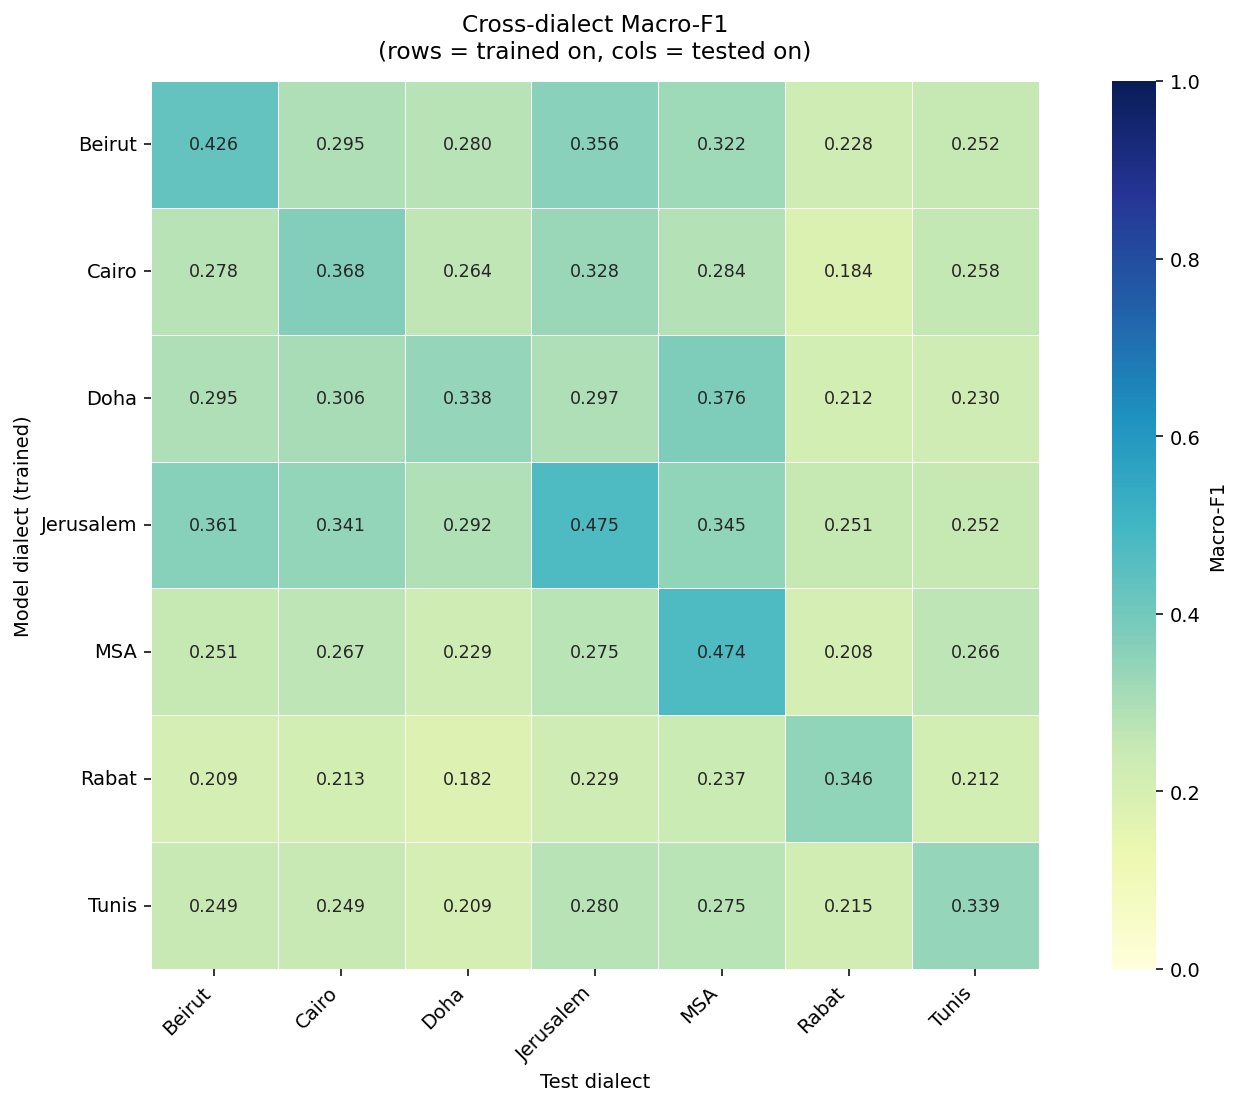

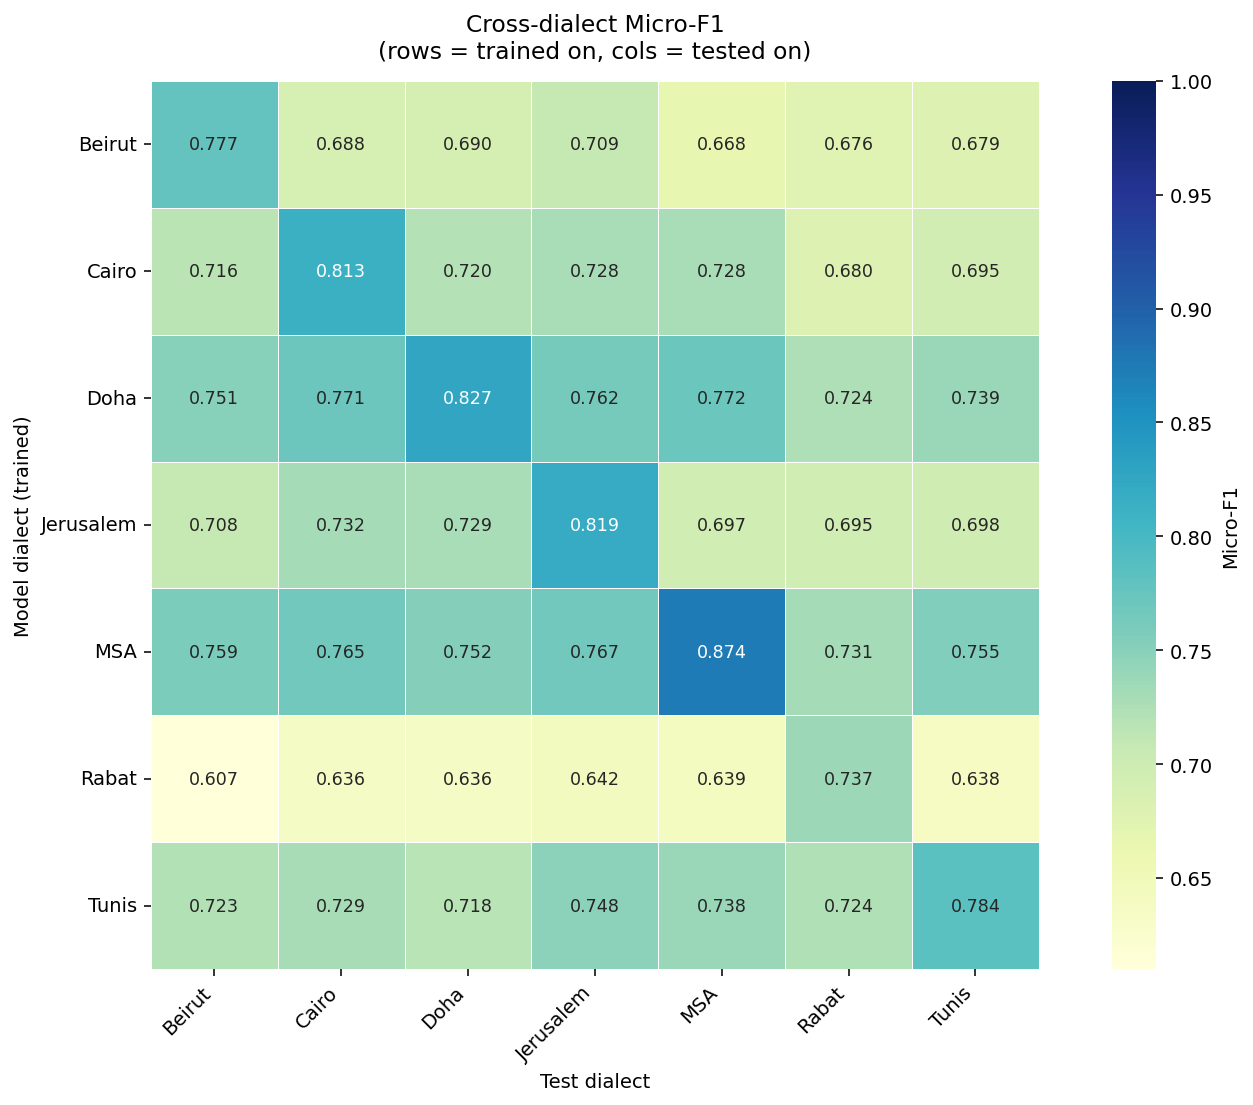

Saved: outputs/eval/macro_f1_heatmap.png | outputs/eval/micro_f1_heatmap.png


In [13]:
# Build matrices
macro_df = pd.DataFrame(macro_f1_matrix)
micro_df = pd.DataFrame(micro_f1_matrix)

# Consistent order
dialects = sorted(set(macro_df.index).union(macro_df.columns)
                  .union(micro_df.index).union(micro_df.columns))
macro_df = macro_df.reindex(index=dialects, columns=dialects)
micro_df = micro_df.reindex(index=dialects, columns=dialects)

# --- Macro-F1 heatmap (YlGnBu) ---
fig, ax = plt.subplots(figsize=(11, 8), dpi=140)
sns.heatmap(
    macro_df, ax=ax, annot=True, fmt=".3f",
    cmap="YlGnBu", vmin=0.0, vmax=1.0,
    linewidths=.5, linecolor="white", square=True,
    cbar_kws={"label": "Macro-F1"}, annot_kws={"size": 9}
)
ax.set_title("Cross-dialect Macro-F1\n(rows = trained on, cols = tested on)", pad=12)
ax.set_xlabel("Test dialect"); ax.set_ylabel("Model dialect (trained)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
fig.tight_layout()
macro_png = os.path.join(EVAL_ROOT, "macro_f1_heatmap.png")
fig.savefig(macro_png, bbox_inches="tight", dpi=140)   # <-- save BEFORE show
plt.show()
plt.close(fig)

# --- Micro-F1 heatmap (different palette + tighter range) ---
micro_min = float(micro_df.min().min()) if not micro_df.empty else 0.0
vmin = max(0.6, round(micro_min, 2))  # adjust threshold to taste

fig, ax = plt.subplots(figsize=(11, 8), dpi=140)
sns.heatmap(
    micro_df, ax=ax, annot=True, fmt=".3f",
    cmap="YlGnBu", vmin=vmin, vmax=1.0,   # different palette, tighter scale
    linewidths=.5, linecolor="white", square=True,
    cbar_kws={"label": "Micro-F1"}, annot_kws={"size": 9}
)
ax.set_title("Cross-dialect Micro-F1\n(rows = trained on, cols = tested on)", pad=12)
ax.set_xlabel("Test dialect"); ax.set_ylabel("Model dialect (trained)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
fig.tight_layout()
micro_png = os.path.join(EVAL_ROOT, "micro_f1_heatmap.png")
fig.savefig(micro_png, bbox_inches="tight", dpi=140)   # <-- save BEFORE show
plt.show()
plt.close(fig)

print("Saved:", macro_png, "|", micro_png)



Most confused pair eval

/var/folders/v9/w_hnh60x1m9fdzpm0_2cbwsc0000gn/T/ipykernel_94194/2410567145.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="pair", x="count", ax=ax, palette="Reds")


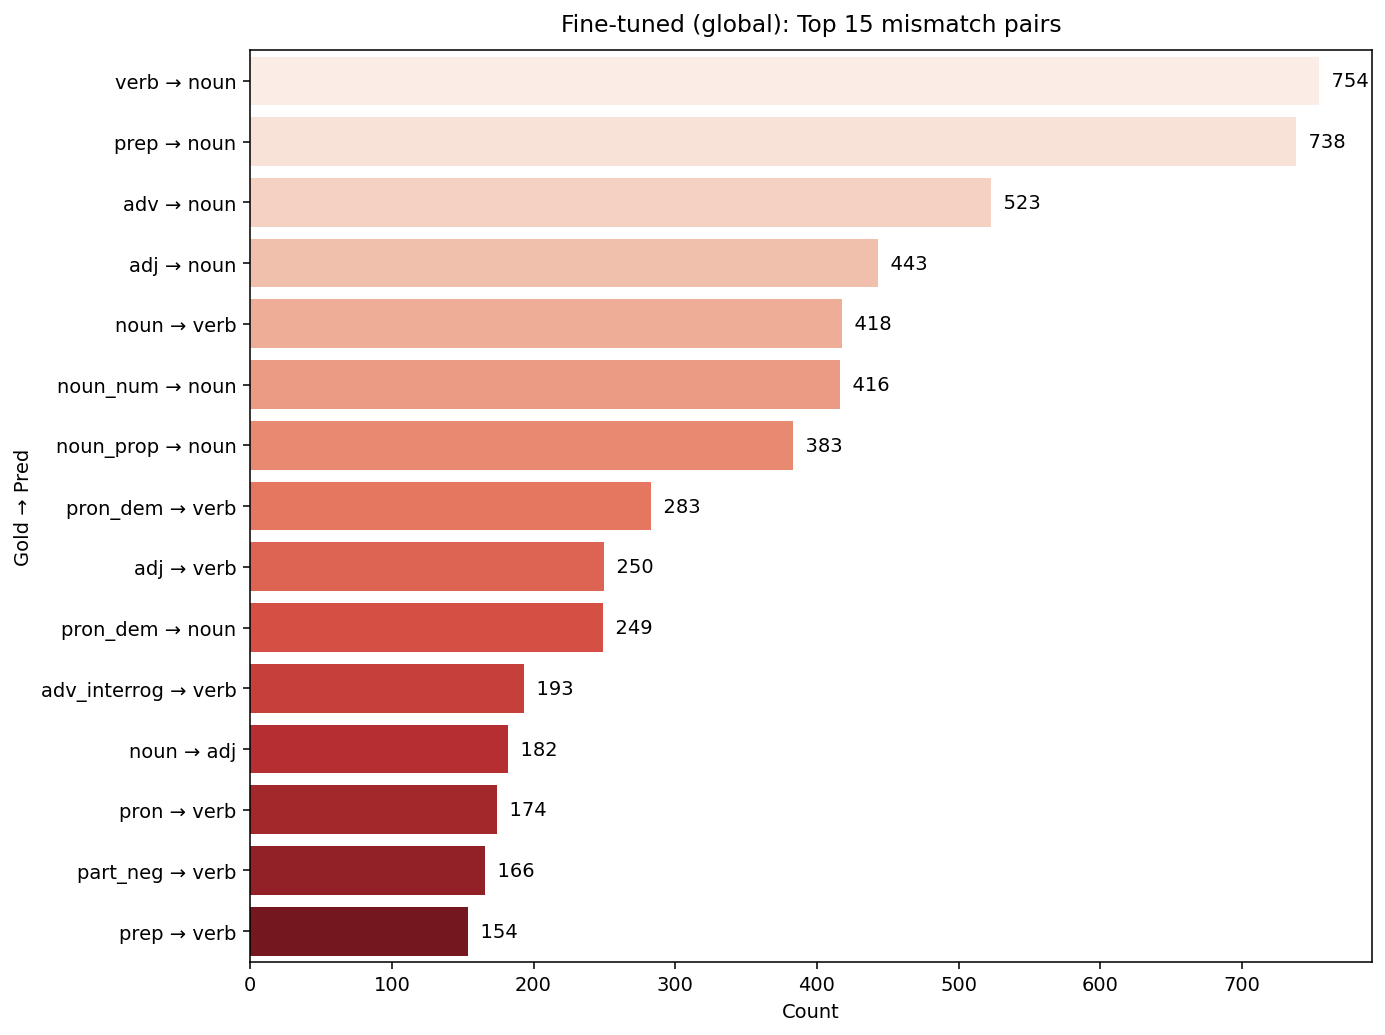

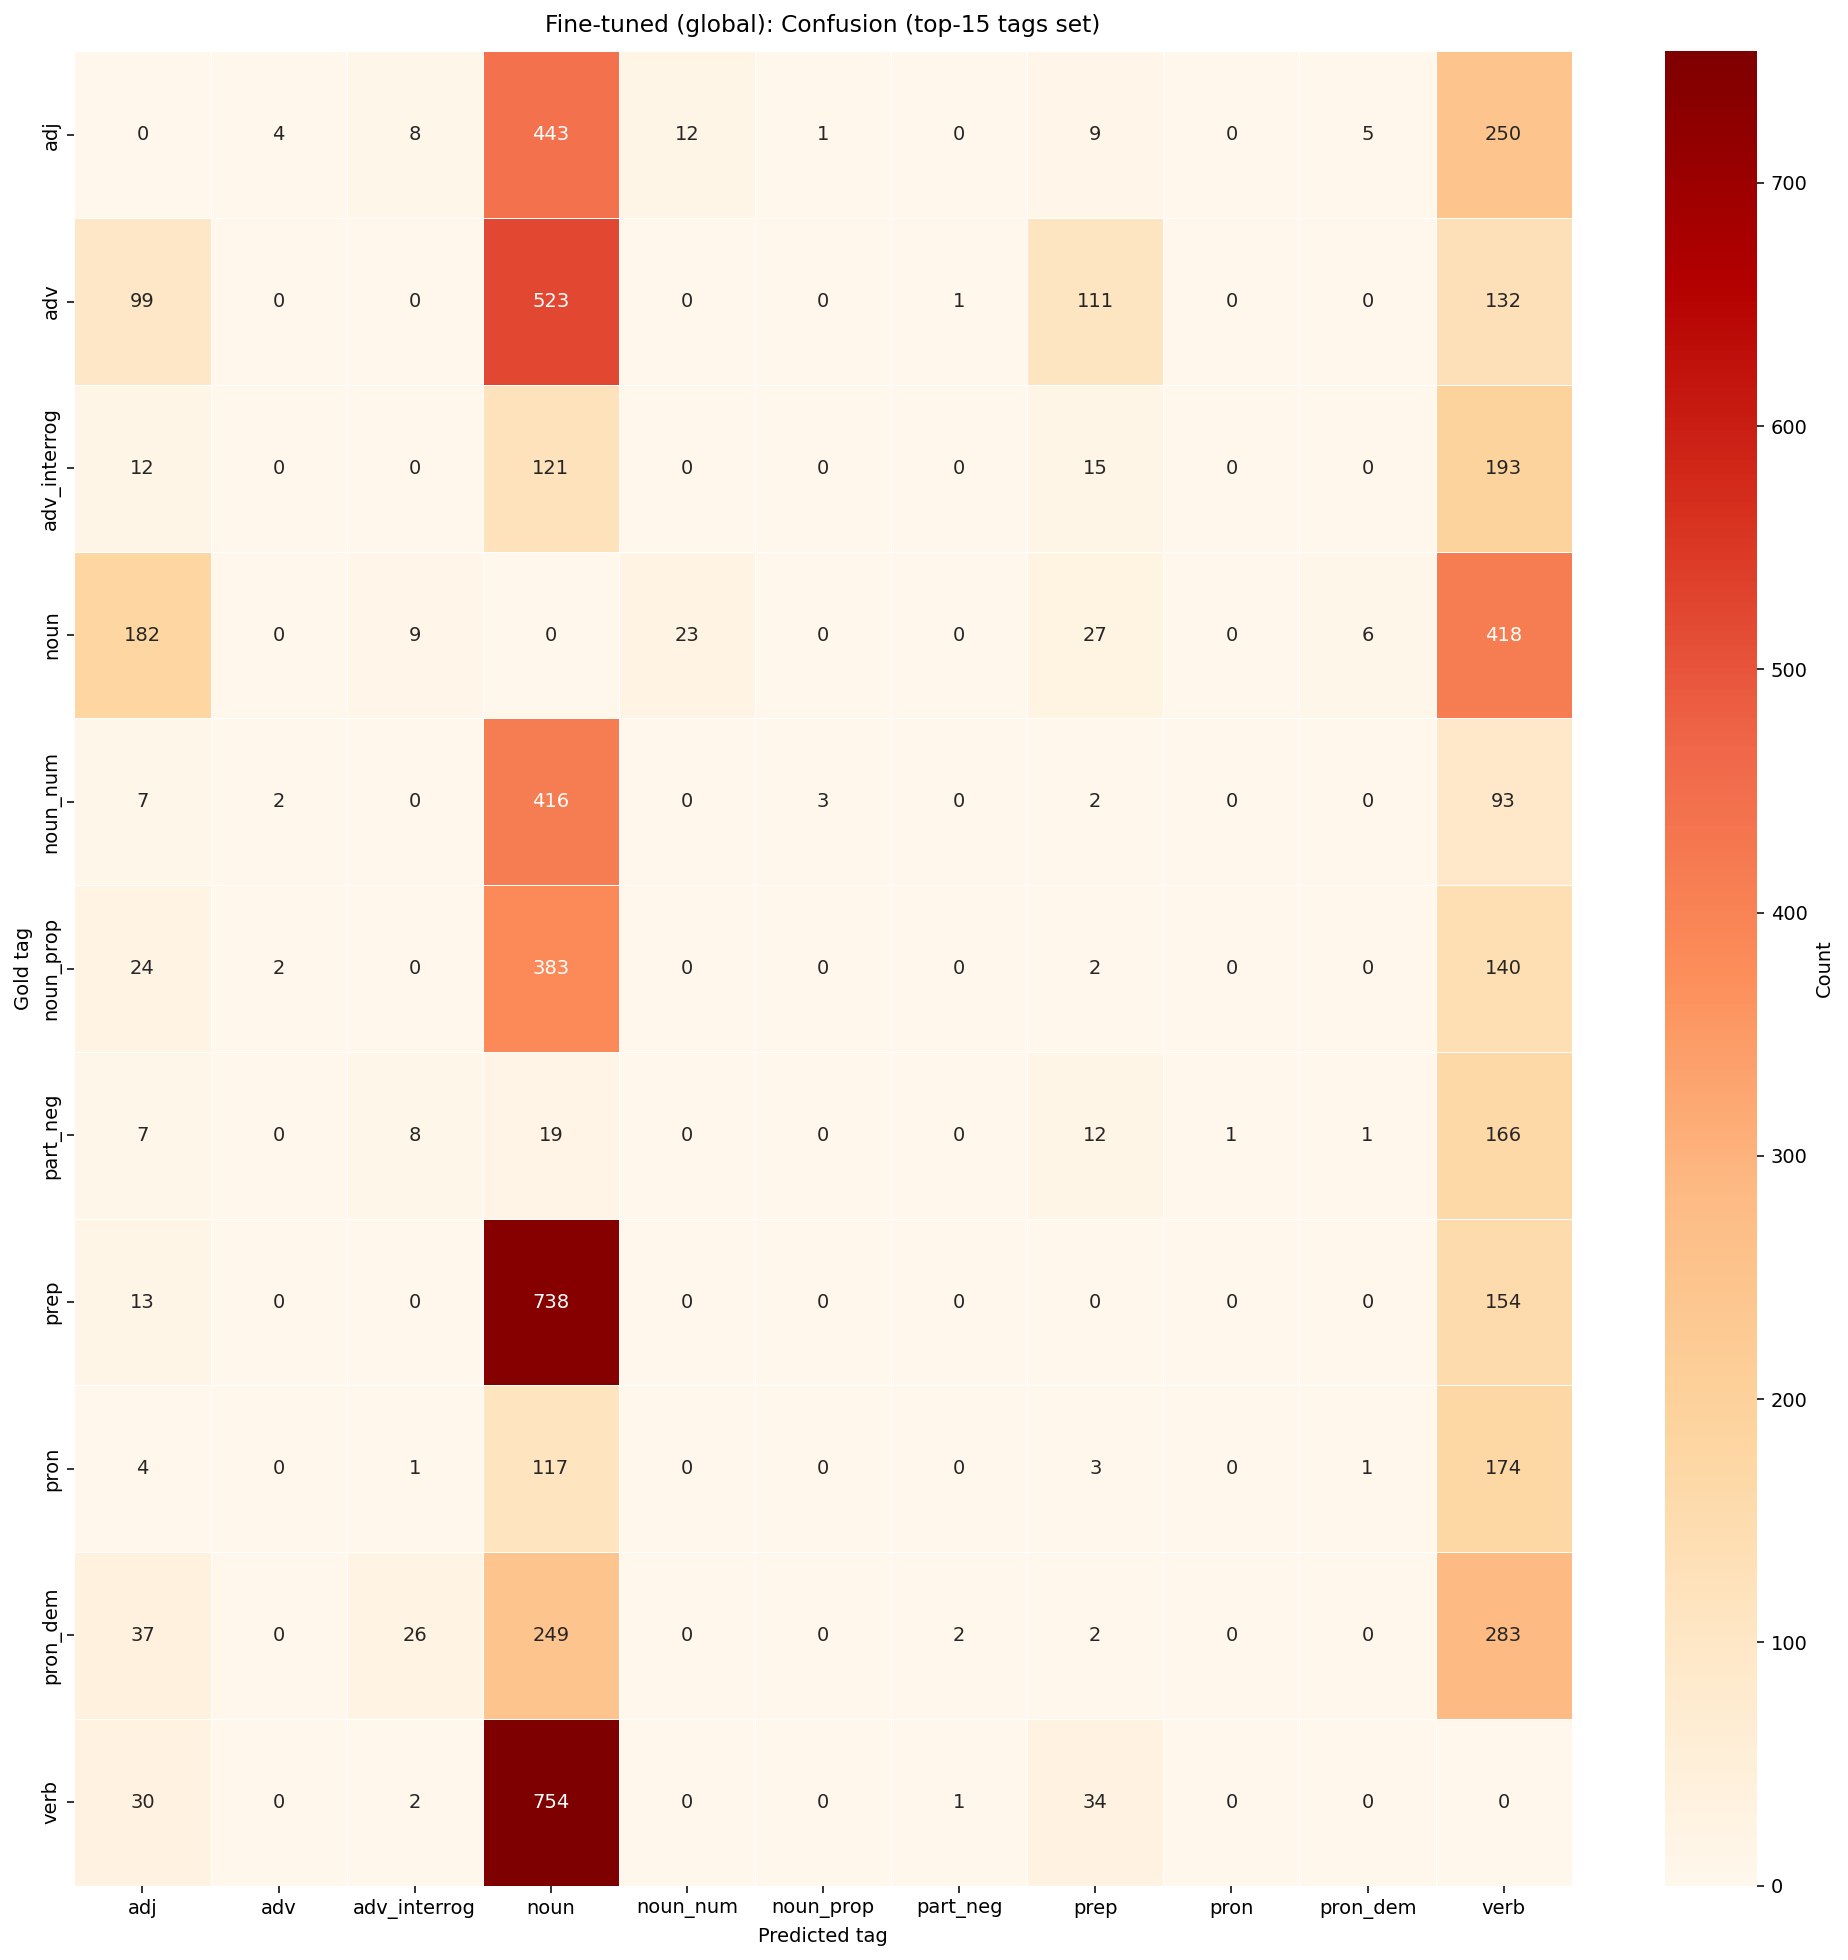

Saved: outputs/eval/finetuned_global_top15_mismatches_bar.png | outputs/eval/finetuned_global_top15_mismatches_heatmap.png


In [14]:
# Visualize mismatch pairs (zero-shot + after fine-tuning)

# ---------- aggregate mismatches across all dialects ----------
agg_pairs_finetuned = defaultdict(int)
for dialect, pairs in mismatch_pairs_after_finetune.items():
    for (g, p), cnt in pairs.items():
        agg_pairs_finetuned[(g, p)] += cnt

# Top-K global mismatch pairs
agg_df = pairs_to_df(agg_pairs_finetuned, TOP_K)

# Bar chart (global)
bar_png = os.path.join(EVAL_ROOT, f"finetuned_global_top{TOP_K}_mismatches_bar.png")
plot_top_pairs_bar(agg_df, f"Fine-tuned (global): Top {TOP_K} mismatch pairs", bar_png)

# Confusion heatmap limited to tags appearing in the top-K pairs
tags_for_heatmap = set(agg_df["gold"]).union(set(agg_df["pred"])) if not agg_df.empty else set()
hm_png = os.path.join(EVAL_ROOT, f"finetuned_global_top{TOP_K}_mismatches_heatmap.png")
plot_top_tags_heatmap(
    agg_pairs_finetuned, tags_for_heatmap,
    f"Fine-tuned (global): Confusion (top-{TOP_K} tags set)",
    hm_png
)

print("Saved:", bar_png, "|", hm_png)

